# Set Up Your Environment

Install necessary tools

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, lit, when, max as spark_max, min as spark_min
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow dask


Install PySpark via pip

In [3]:
pip install pyspark


Verify Installation

In [4]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.master("local[*]").appName("PySparkTest").getOrCreate()

# Check Spark version
print("Spark version:", spark.version)


Spark version: 3.5.4


List Uploaded Files

In [5]:
import os

# List all files in the 'content' directory
uploaded_files = os.listdir('/content')
print("Uploaded Files:", uploaded_files)


Uploaded Files: ['.config', 'fh_5yrs.csv', 'sample_data']


Load All Files

In [6]:
df = spark.read.csv(f'/content/fh_5yrs.csv', header=True, inferSchema=True)


In order to analyse further, sample of data belong to 6 companies analyze further

In [7]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.master("local[*]").appName("StockDataAnalysis").getOrCreate()

# Load all CSV files from the content folder
combined_df = spark.read.csv('/content/*.csv', header=True, inferSchema=True)
combined_df.show(5)  # Display the first 5 rows
combined_df.printSchema()  # Check the structure of the dataset


+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|257500|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|17.709999084472656|  AAAU|
|2020-07-01|468100|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-30|319100|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|17.780000686645508|  AAAU|
|2020-06-29|405500|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-26|335100|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|17.670000076293945|  AAAU|
+----------+------+-----

Data Characterization

View the First Few Records

In [8]:
df.show(5)

+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|257500|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|17.709999084472656|  AAAU|
|2020-07-01|468100|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-30|319100|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|17.780000686645508|  AAAU|
|2020-06-29|405500|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-26|335100|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|17.670000076293945|  AAAU|
+----------+------+-----

 Schema (data types)

In [9]:
df.printSchema()


root
 |-- date: date (nullable = true)
 |-- volume: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)



Number of Records and Features

In [10]:
#Count the Rows (Records)
num_records = df.count()
print(f"Number of records (rows): {num_records}")

#Count the Columns (Features)
num_features = len(df.columns)
print(f"Number of features (columns): {num_features}")


Number of records (rows): 96163
Number of features (columns): 8


In [11]:
# Group columns by data type
string_columns = [col for col, dtype in df.dtypes if dtype == 'string']
numeric_columns = [col for col, dtype in df.dtypes if dtype in ['int', 'double']]

print("String Columns:", string_columns)
print("Numeric Columns:", numeric_columns)


String Columns: ['symbol']
Numeric Columns: ['volume', 'open', 'high', 'low', 'close', 'adjclose']


Unique Symbols (Companies)

In [12]:
unique_symbols = df.select("symbol").distinct().count()
print(f"Number of unique companies: {unique_symbols}")


Number of unique companies: 85


## Pre processing

Check Missing values

In [13]:
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+----+------+----+----+---+-----+--------+------+
|date|volume|open|high|low|close|adjclose|symbol|
+----+------+----+----+---+-----+--------+------+
|   0|     0|   0|   0|  0|    0|       0|     0|
+----+------+----+----+---+-----+--------+------+



Ensure correct data types

In [14]:
df = df.withColumn("date", df["date"].cast("date"))
df = df.withColumn("close", df["close"].cast("double"))


Date Range

In [15]:
from pyspark.sql.functions import min, max

date_range = df.select(min("date").alias("Earliest Date"), max("date").alias("Latest Date"))
date_range.show()


+-------------+-----------+
|Earliest Date|Latest Date|
+-------------+-----------+
|   2015-01-02| 2020-07-02|
+-------------+-----------+



Calculate Date Range for each company

In [16]:
from pyspark.sql.functions import min, max

# Group by symbol and calculate earliest and latest dates
date_range_df = df.groupBy("symbol").agg(
    min("date").alias("Earliest Date"),
    max("date").alias("Latest Date")
)

# Show results
date_range_df.show(truncate=False)


+------+-------------+-----------+
|symbol|Earliest Date|Latest Date|
+------+-------------+-----------+
|AAT   |2015-01-02   |2020-07-02 |
|ACCO  |2015-01-02   |2020-07-02 |
|ACH   |2015-01-02   |2020-07-02 |
|AAPL  |2015-01-02   |2020-07-02 |
|ACGLO |2017-08-21   |2020-07-02 |
|AAMC  |2015-01-02   |2020-07-02 |
|ACA   |2018-11-05   |2020-07-02 |
|ABM   |2015-01-02   |2020-07-02 |
|ACGLP |2016-09-23   |2020-07-02 |
|AACG  |2019-03-11   |2020-07-02 |
|ABEO  |2015-01-02   |2020-07-02 |
|ACC   |2015-01-02   |2020-06-19 |
|ACN   |2015-01-02   |2020-07-02 |
|ABTX  |2015-10-08   |2020-07-02 |
|ABIO  |2015-01-02   |2020-07-02 |
|ABEV  |2015-01-02   |2020-07-02 |
|ABBV  |2015-01-02   |2020-07-02 |
|ACNB  |2015-01-02   |2020-07-02 |
|ACHV  |2015-01-02   |2020-07-02 |
|AAP   |2015-01-02   |2020-07-02 |
+------+-------------+-----------+
only showing top 20 rows



 Top/Bottom Prices

In [17]:
from pyspark.sql.functions import max, min

# Group by symbol and calculate max and min close prices
price_summary = df.groupBy("symbol").agg(
    max("close").alias("Max Close Price"),
    min("close").alias("Min Close Price")
)

# Show the results
price_summary.show(truncate=False)


+------+------------------+-------------------+
|symbol|Max Close Price   |Min Close Price    |
+------+------------------+-------------------+
|AAT   |48.959999084472656|21.479999542236328 |
|ACCO  |14.699999809265135|3.890000104904175  |
|ACH   |23.45000076293945 |4.6599998474121085 |
|AAPL  |366.5299987792969 |90.33999633789062  |
|ACGLO |26.687000274658203|16.809999465942386 |
|AAMC  |342.8500061035156 |7.989999771118164  |
|ACA   |47.66999816894531 |23.1200008392334   |
|ABM   |44.790000915527344|20.450000762939453 |
|ACGLP |26.040000915527344|16.399999618530273 |
|AACG  |3.849999904632568 |0.6700000166893005 |
|ABEO  |21.450000762939453|1.4500000476837158 |
|ACC   |54.54999923706055 |20.76000022888184  |
|ACN   |217.32000732421875|84.02999877929688  |
|ABTX  |45.599998474121094|16.360000610351562 |
|ABIO  |190.25999450683597|2.3199999332427983 |
|ABEV  |7.389999866485597 |1.940000057220459  |
|ABBV  |123.20999908447266|48.27000045776367  |
|ACNB  |40.93999862670898 |19.6499996185

Filter High Performers

In [18]:
top_performers = price_summary.orderBy("Max Close Price", ascending=False)
top_performers.show(10)


+------+------------------+-------------------+
|symbol|   Max Close Price|    Min Close Price|
+------+------------------+-------------------+
|   ACI|            7250.0| 15.449999809265135|
|  ADBE|442.95001220703125|  69.98999786376953|
|  ACHV|             396.0|0.23000000417232516|
|  AAPL| 366.5299987792969|  90.33999633789062|
|  AAMC| 342.8500061035156|  7.989999771118164|
|   ACN|217.32000732421875|  84.02999877929688|
|   AAP| 200.3800048828125|  75.02999877929688|
|  ABIO|190.25999450683597| 2.3199999332427983|
|   ADP|            181.25| 109.06999969482422|
|   ACB|143.26800537109375|  2.400000095367432|
+------+------------------+-------------------+
only showing top 10 rows



Filter Low Performers

In [19]:
low_performers = price_summary.orderBy("Min Close Price", ascending=True)
low_performers.show(10)


+------+------------------+-------------------+
|symbol|   Max Close Price|    Min Close Price|
+------+------------------+-------------------+
|  ACHV|             396.0|0.23000000417232516|
|   AAU| 1.809999942779541|  0.239999994635582|
|  ADMP|10.119999885559082|0.33000001311302185|
|  AACG| 3.849999904632568| 0.6700000166893005|
|  ADAP|  21.1200008392334| 0.7250000238418579|
|  ACRS|32.990001678466804|               0.75|
|  ACRX| 9.130000114440918| 0.7599999904632568|
|   ACY| 17.34000015258789| 0.8000000119209291|
|  ABUS| 26.26000022888184| 0.8700000047683716|
|  ADIL| 8.329999923706055| 1.0499999523162842|
+------+------------------+-------------------+
only showing top 10 rows



Visualize Top and Bottom Prices

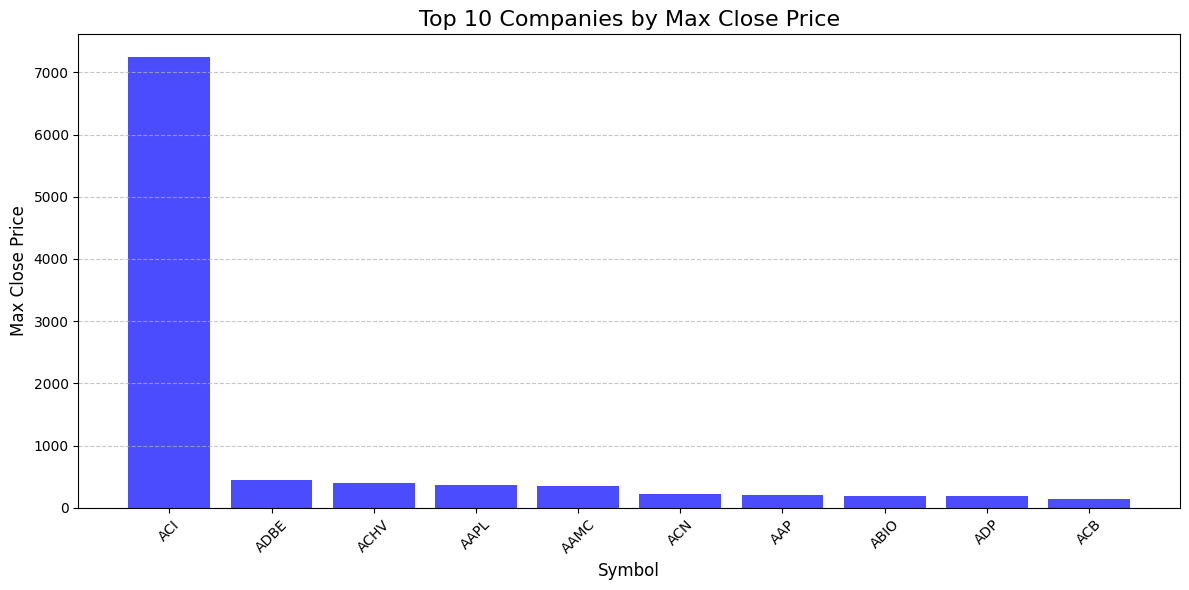

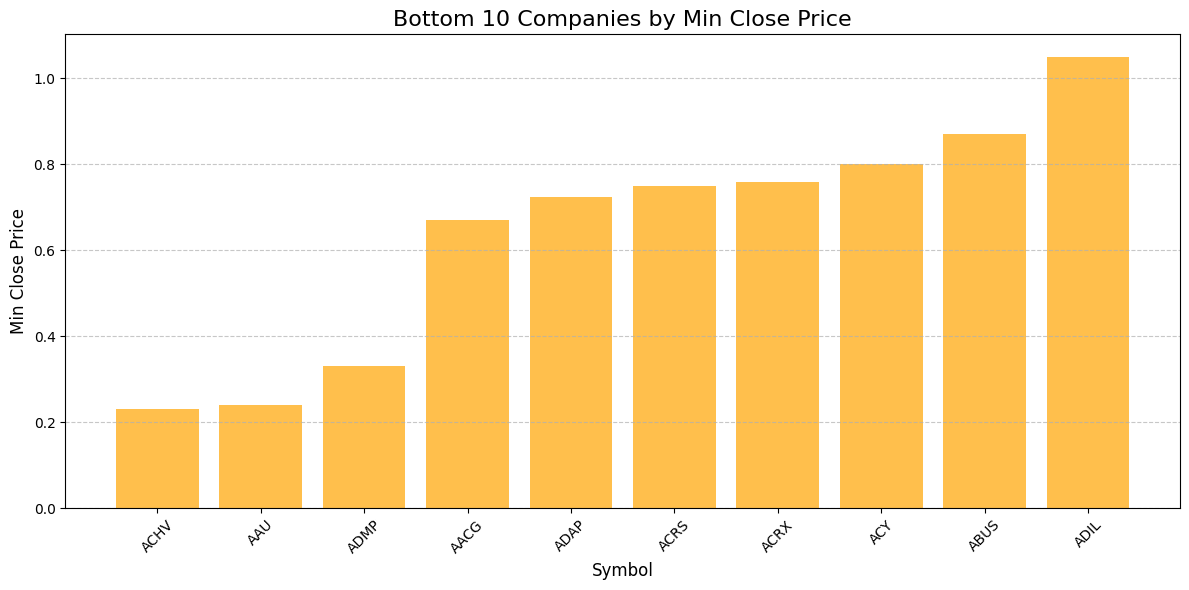

In [20]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
pandas_price_summary = price_summary.toPandas()

# Sort data for max and min close prices
top_10_max = pandas_price_summary.sort_values(by="Max Close Price", ascending=False).head(10)
bottom_10_min = pandas_price_summary.sort_values(by="Min Close Price", ascending=True).head(10)

# Plot Top 10 Max Close Prices
plt.figure(figsize=(12, 6))
plt.bar(top_10_max['symbol'], top_10_max['Max Close Price'], color='blue', alpha=0.7)
plt.title("Top 10 Companies by Max Close Price", fontsize=16)
plt.xlabel("Symbol", fontsize=12)
plt.ylabel("Max Close Price", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Bottom 10 Min Close Prices
plt.figure(figsize=(12, 6))
plt.bar(bottom_10_min['symbol'], bottom_10_min['Min Close Price'], color='orange', alpha=0.7)
plt.title("Bottom 10 Companies by Min Close Price", fontsize=16)
plt.xlabel("Symbol", fontsize=12)
plt.ylabel("Min Close Price", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 Identify the Target Variable

In [21]:
if 'close' in df.columns:
    print("Target variable 'close' exists in the dataset.")
else:
    print("Target variable 'close' not found. Check column names:", df.columns)


Target variable 'close' exists in the dataset.


Distribution of features

In [22]:
# Group by symbol and count the number of records for each
record_count_by_symbol = df.groupBy("symbol").count().orderBy("count", ascending=False)

# Show the top 10 companies with the highest record counts
record_count_by_symbol.show(10, truncate=False)

# Show the top 10 companies with the lowest record counts
record_count_by_symbol.orderBy("count").show(10, truncate=False)


+------+-----+
|symbol|count|
+------+-----+
|AAON  |1385 |
|ACN   |1385 |
|AAT   |1385 |
|ACCO  |1385 |
|ACH   |1385 |
|AAPL  |1385 |
|ABEV  |1385 |
|ABEO  |1385 |
|ABBV  |1385 |
|ACHV  |1385 |
+------+-----+
only showing top 10 rows

+------+-----+
|symbol|count|
+------+-----+
|ADCT  |24   |
|ABEQ  |114  |
|ACTTU |173  |
|ACAM  |194  |
|ADP   |237  |
|ACTT  |249  |
|ACSG  |269  |
|ACEL  |327  |
|AACG  |333  |
|ACA   |417  |
+------+-----+
only showing top 10 rows



Visualize Record Counts

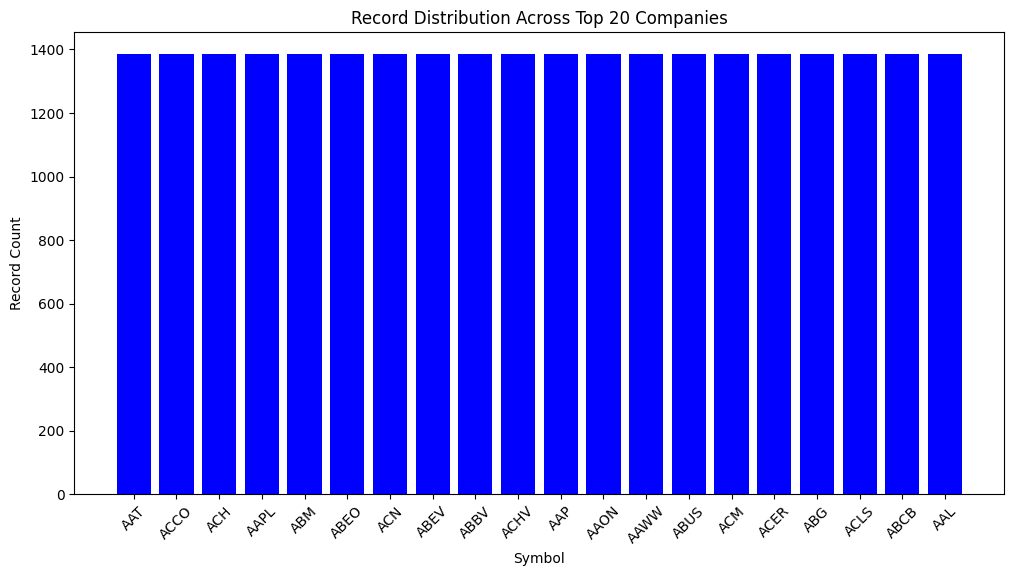

In [23]:
# Convert to Pandas for visualization
pandas_record_count = record_count_by_symbol.toPandas()

import matplotlib.pyplot as plt

# Plot bar chart for record distribution (e.g., top 20 companies)
plt.figure(figsize=(12, 6))
plt.bar(pandas_record_count["symbol"][:20], pandas_record_count["count"][:20], color="blue")
plt.title("Record Distribution Across Top 20 Companies")
plt.xlabel("Symbol")
plt.ylabel("Record Count")
plt.xticks(rotation=45)
plt.show()


Summary Statistics

In [24]:
# Group by symbol and calculate basic statistics for close prices
summary_stats = df.groupBy("symbol").agg(
    {"close": "avg", "volume": "avg", "close": "stddev"}
).withColumnRenamed("avg(close)", "avg_close") \
 .withColumnRenamed("stddev(close)", "stddev_close") \
 .withColumnRenamed("avg(volume)", "avg_volume")

# Show summary statistics
summary_stats.show(10, truncate=False)


+------+-------------------+------------------+
|symbol|avg_volume         |stddev_close      |
+------+-------------------+------------------+
|AAT   |260853.2129963899  |4.891128308326651 |
|ACCO  |605186.8592057761  |2.3413599468470574|
|ACH   |74707.14801444043  |3.689902676023027 |
|AAPL  |3.653794259927798E7|60.88873372877766 |
|ACGLO |45098.19944598338  |1.3906964745353507|
|AAMC  |12919.476520400309 |57.7879262289816  |
|ACA   |391995.6834532374  |5.449604548342071 |
|ABM   |415438.70036101085 |4.864231102565184 |
|ACGLP |76697.05263157895  |1.3763981633506572|
|AACG  |484001.5015015015  |0.6075128150602996|
+------+-------------------+------------------+
only showing top 10 rows



In [25]:
summary_stats.write.csv("summary_stats.csv", header=True)


In [26]:
import pandas as pd

# Load the uploaded file
file_path = '/content/summary_stats.csv/part-00000-a8aa26b3-6c28-43ff-9aa0-8754e7970283-c000.csv'
data_distribution = pd.read_csv(file_path)

# Display the first few rows of the dataset and basic information
data_distribution.head(), data_distribution.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   symbol        85 non-null     object 
 1   avg_volume    85 non-null     float64
 2   stddev_close  85 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.1+ KB


(  symbol    avg_volume  stddev_close
 0    AAT  2.608532e+05      4.891128
 1   ACCO  6.051869e+05      2.341360
 2    ACH  7.470715e+04      3.689903
 3   AAPL  3.653794e+07     60.888734
 4  ACGLO  4.509820e+04      1.390696,
 None)

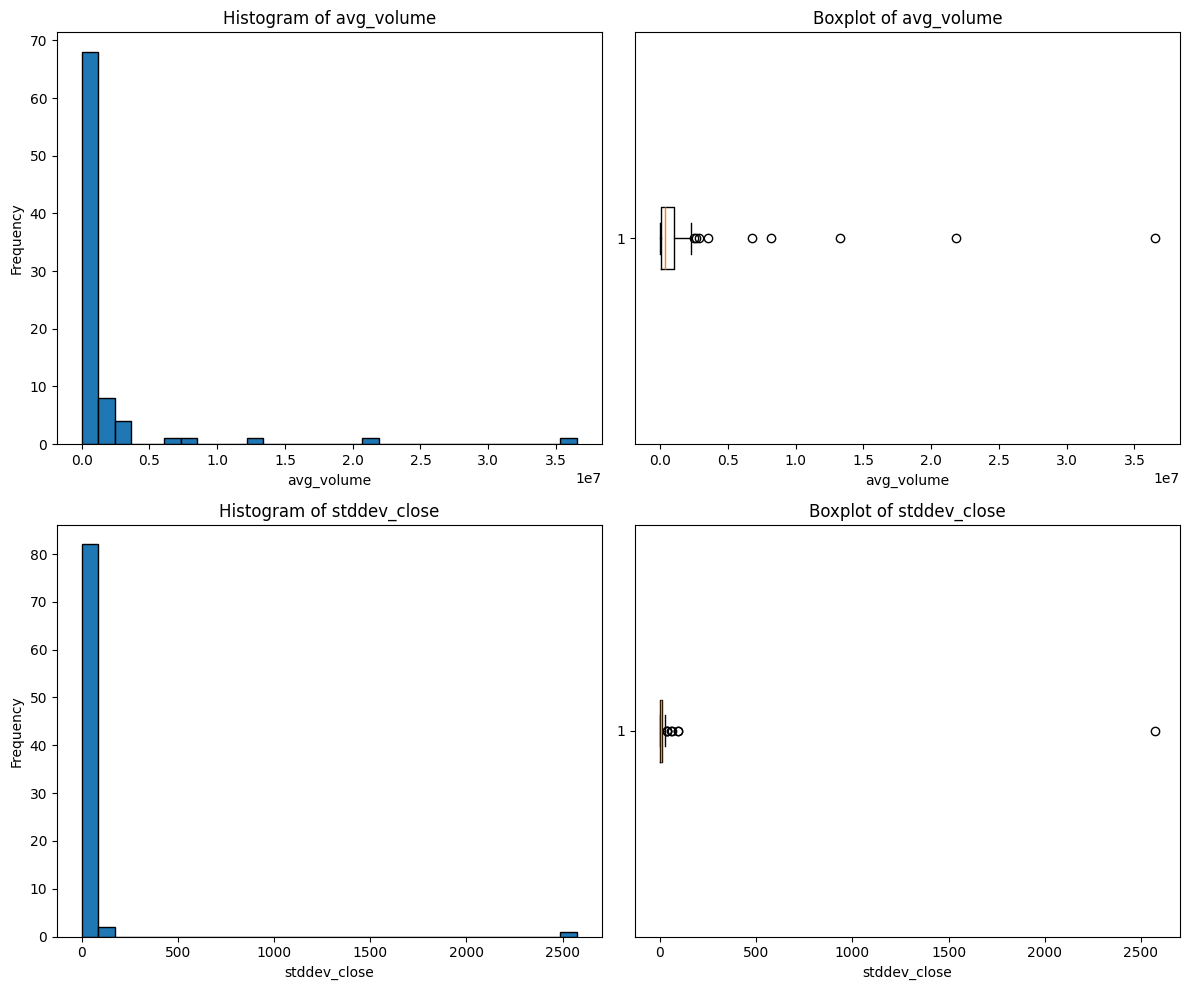

In [27]:
import matplotlib.pyplot as plt

data= data_distribution
# Summary statistics for numeric columns
summary_stats = data.describe()

# Visualize distributions with histograms and boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for avg_volume
axes[0, 0].hist(data['avg_volume'], bins=30, edgecolor='k')
axes[0, 0].set_title('Histogram of avg_volume')
axes[0, 0].set_xlabel('avg_volume')
axes[0, 0].set_ylabel('Frequency')

# Boxplot for avg_volume
axes[0, 1].boxplot(data['avg_volume'], vert=False)
axes[0, 1].set_title('Boxplot of avg_volume')
axes[0, 1].set_xlabel('avg_volume')

# Histogram for stddev_close
axes[1, 0].hist(data['stddev_close'].dropna(), bins=30, edgecolor='k')
axes[1, 0].set_title('Histogram of stddev_close')
axes[1, 0].set_xlabel('stddev_close')
axes[1, 0].set_ylabel('Frequency')

# Boxplot for stddev_close
axes[1, 1].boxplot(data['stddev_close'].dropna(), vert=False)
axes[1, 1].set_title('Boxplot of stddev_close')
axes[1, 1].set_xlabel('stddev_close')

plt.tight_layout()
plt.show()



In [28]:
# Extract necessary statistics for CV and percentiles calculation
mean_avg_volume = data['avg_volume'].mean()
std_avg_volume = data['avg_volume'].std()

mean_stddev_close = data['stddev_close'].mean()
std_stddev_close = data['stddev_close'].std()

# Compute Coefficient of Variation (CV)
cv_avg_volume = std_avg_volume / mean_avg_volume
cv_stddev_close = std_stddev_close / mean_stddev_close

# Percentiles for avg_volume and stddev_close
percentiles_avg_volume = data['avg_volume'].quantile([0.25, 0.5, 0.75])
percentiles_stddev_close = data['stddev_close'].quantile([0.25, 0.5, 0.75])

# Prepare results
distribution_analysis = {
    "CV_avg_volume": cv_avg_volume,
    "CV_stddev_close": cv_stddev_close,
    "Percentiles_avg_volume": percentiles_avg_volume.to_dict(),
    "Percentiles_stddev_close": percentiles_stddev_close.to_dict()
}

distribution_analysis


{'CV_avg_volume': 3.0048525458537134,
 'CV_stddev_close': 6.814361989244469,
 'Percentiles_avg_volume': {0.25: 91091.50943396226,
  0.5: 360033.26488706365,
  0.75: 1019593.8226744186},
 'Percentiles_stddev_close': {0.25: 2.3413599468470574,
  0.5: 4.837760117630144,
  0.75: 12.38638277447432}}

Visualize price and volume

+------+------------------+------------------+--------------------+--------------------+-------------+
|symbol|        mean_close|      stddev_close|         mean_volume|       stddev_volume|count_entries|
+------+------------------+------------------+--------------------+--------------------+-------------+
|   AAT|40.320707549773395| 4.891128308326651|   260853.2129963899|   235991.6647460791|         1385|
|  ACCO| 9.801465703089745|2.3413599468470574|   605186.8592057761|   305573.8875730402|         1385|
|   ACH|10.721523456366914| 3.689902676023027|   74707.14801444043|    83578.9040819482|         1385|
|  AAPL|168.10501793265772| 60.88873372877766| 3.653794259927798E7|1.8070004946072605E7|         1385|
| ACGLO| 24.52429222730388|1.3906964745353507|   45098.19944598338|    62675.5191769834|          722|
|  AAMC| 57.19272523590746|  57.7879262289816|  12919.476520400309|   22094.15865959186|         1299|
|   ACA|35.647625888851906| 5.449604548342071|   391995.6834532374|  3648

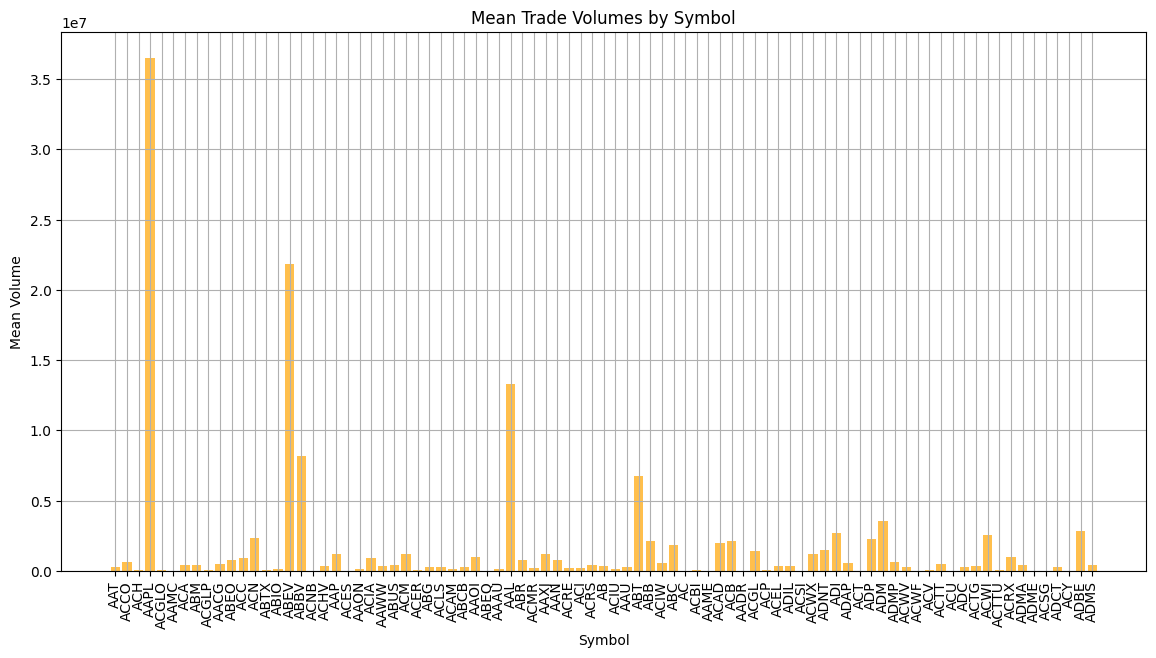

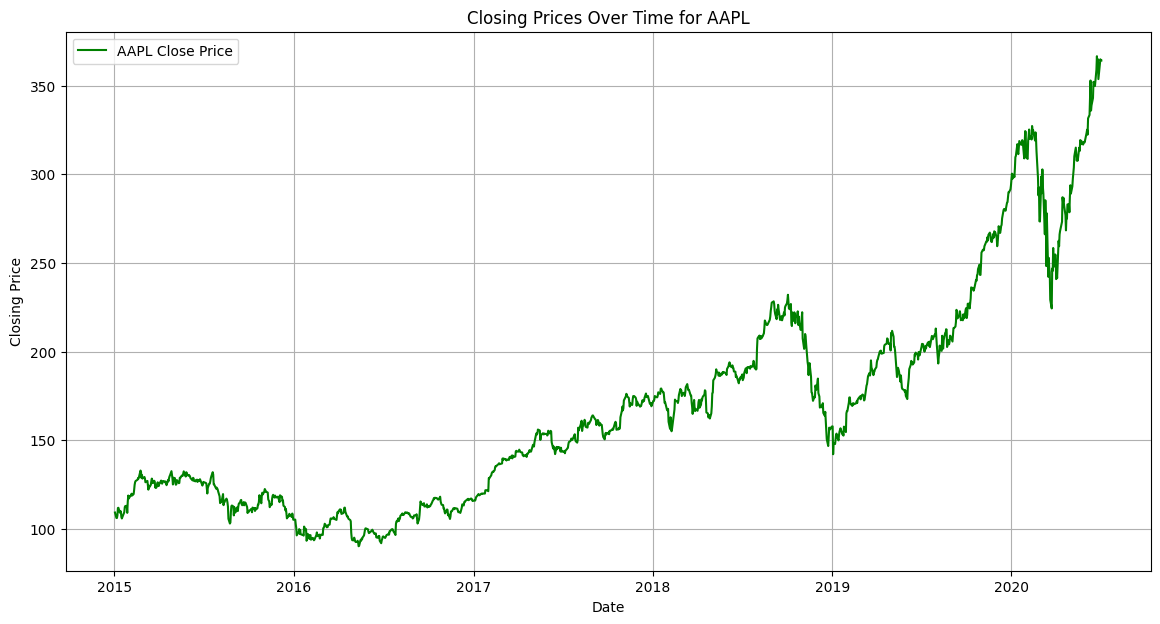

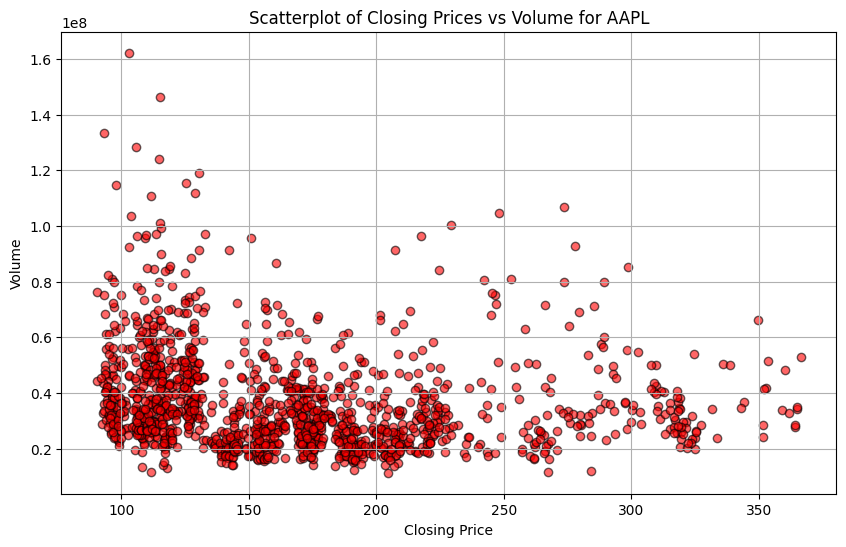

In [29]:
# Import necessary libraries
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Group data by symbol and calculate summary statistics for each symbol
grouped_stats = df.groupBy("symbol").agg(
    F.mean("close").alias("mean_close"),
    F.stddev("close").alias("stddev_close"),
    F.mean("volume").alias("mean_volume"),
    F.stddev("volume").alias("stddev_volume"),
    F.count("close").alias("count_entries")
)

# Show the summary statistics for each symbol
grouped_stats.show()

# Convert grouped statistics to Pandas DataFrame for visualization
pandas_grouped_stats = grouped_stats.toPandas()


# 2. Bar Plot of Mean Volume for Each Symbol
plt.figure(figsize=(14, 7))
plt.bar(pandas_grouped_stats["symbol"], pandas_grouped_stats["mean_volume"], color="orange", alpha=0.7)
plt.title("Mean Trade Volumes by Symbol")
plt.xlabel("Symbol")
plt.ylabel("Mean Volume")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# 3. Line Chart of Closing Prices Over Time for Each Symbol
# Filter a specific symbol (e.g., AAPL) for demonstration
symbol_data = df.filter(F.col("symbol") == "AAPL").orderBy("date").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(symbol_data["date"], symbol_data["close"], label="AAPL Close Price", color="green")
plt.title("Closing Prices Over Time for AAPL")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# 4. Scatterplot of Closing Prices vs. Volume for a Specific Symbol
plt.figure(figsize=(10, 6))
plt.scatter(symbol_data["close"], symbol_data["volume"], alpha=0.6, edgecolors="k", color="red")
plt.title("Scatterplot of Closing Prices vs Volume for AAPL")
plt.xlabel("Closing Price")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Stock Price Changes and Daily Returns

Calculate Daily Price Changes

In [30]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col

window_spec = Window.partitionBy("symbol").orderBy("date")
df = df.withColumn("price_change", col("close") - lag("close", 1).over(window_spec))
df.show(5)


+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|        price_change|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+
|2019-03-11| 32100|1.0800000429153442| 1.100000023841858|1.0800000429153442|1.0800000429153442|1.0800000429153442|  AACG|                NULL|
|2019-03-12| 20200|1.0800000429153442|1.0900000333786009|1.0499999523162842|1.0499999523162842|1.0499999523162842|  AACG|-0.03000009059906006|
|2019-03-13| 23100|1.0599999427795408|1.0800000429153442|1.0399999618530271|1.0700000524520874|1.0700000524520874|  AACG|0.020000100135803223|
|2019-03-14| 29900|1.0599999427795408|1.1100000143051147|1.0599999427795408|1.0800000429153442|1.0800000429153442|  AACG|0.009999990463256836|

Daily Returns Analysis

In [31]:
df = df.withColumn("daily_return", (col("close") - lag("close", 1).over(window_spec)) / lag("close", 1).over(window_spec))
df.show(5)


+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|        price_change|        daily_return|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+
|2019-03-11| 32100|1.0800000429153442| 1.100000023841858|1.0800000429153442|1.0800000429153442|1.0800000429153442|  AACG|                NULL|                NULL|
|2019-03-12| 20200|1.0800000429153442|1.0900000333786009|1.0499999523162842|1.0499999523162842|1.0499999523162842|  AACG|-0.03000009059906006|-0.02777786056200...|
|2019-03-13| 23100|1.0599999427795408|1.0800000429153442|1.0399999618530271|1.0700000524520874|1.0700000524520874|  AACG|0.020000100135803223|0.019047715280065776|
|2019-03-14| 299

Daily Price Range

In [32]:
#df = df.withColumn("daily_range", col("high") - col("low"))
#daily_range_summary = df.groupBy("symbol").agg(avg("daily_range").alias("Avg Daily Range"))
#daily_range_summary.show(10)


In [33]:
from pyspark.sql.functions import col, avg # Import the avg function

df = df.withColumn("daily_range", col("high") - col("low"))
daily_range_summary = df.groupBy("symbol").agg(avg("daily_range").alias("Avg Daily Range"))
daily_range_summary.show(10)

+------+-------------------+
|symbol|    Avg Daily Range|
+------+-------------------+
|   AAT| 0.7807293296290649|
|  ACCO|0.29163175920286766|
|   ACH|0.18772563004751927|
|  AAPL| 3.2330179813536497|
| ACGLO|0.25732409194565886|
|  AAMC| 3.7564126279741363|
|   ACA| 1.3648465382967063|
|   ABM| 0.7783032854541544|
| ACGLP|   0.20790106321636|
|  AACG|0.13531532874694457|
+------+-------------------+
only showing top 10 rows



+------+-------------------+------------------+--------------------+
|symbol|Avg Daily Range    |Max Daily Range   |Min Daily Range     |
+------+-------------------+------------------+--------------------+
|AAT   |0.7807293296290649 |7.810001373291023 |0.23999786376953125 |
|ACCO  |0.29163175920286766|1.7100000381469744|0.059999942779541016|
|ACH   |0.18772563004751927|1.2799997329711896|0.03999996185302557 |
|AAPL  |3.2330179813536497 |26.970016479492244|0.5799942016601562  |
|ACGLO |0.25732409194565886|6.540998458862308 |0.029998779296875   |
|AAMC  |3.7564126279741363 |95.69000244140628 |0.0                 |
|ACA   |1.3648465382967063 |6.150001525878906 |0.29999923706053977 |
|ABM   |0.7783032854541544 |6.0               |0.14999771118164773 |
|ACGLP |0.20790106321636   |4.469999313354496 |0.0                 |
|AACG  |0.13531532874694457|2.2300000190734863|0.0                 |
|ABEO  |0.5262093793614246 |5.55000114440918  |0.0                 |
|ACC   |0.8389897956404575 |9.3000

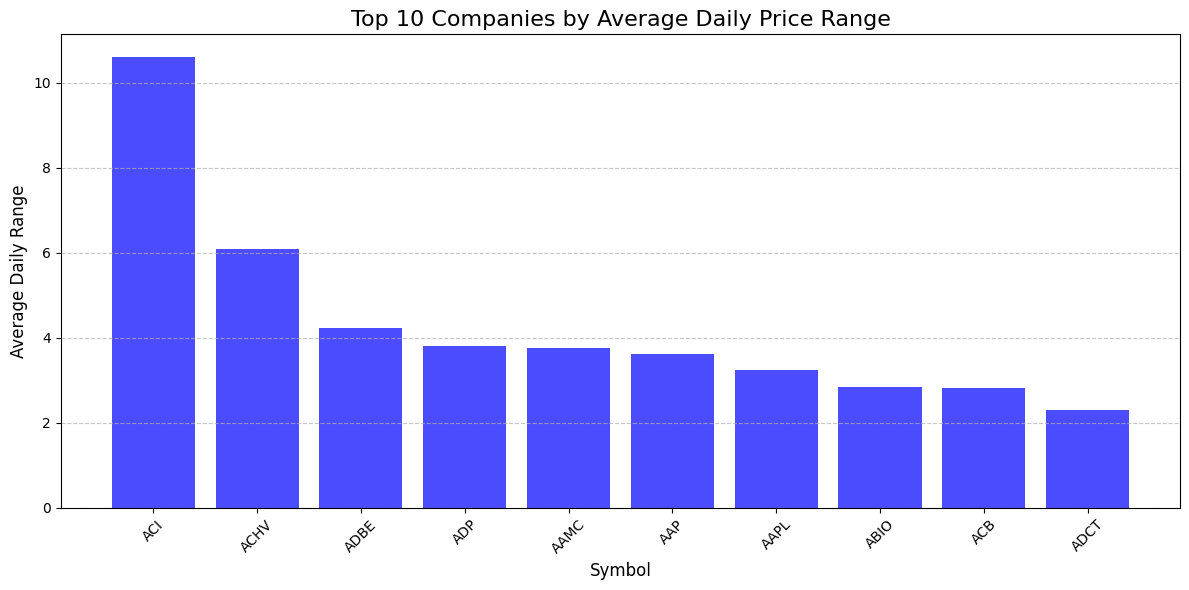

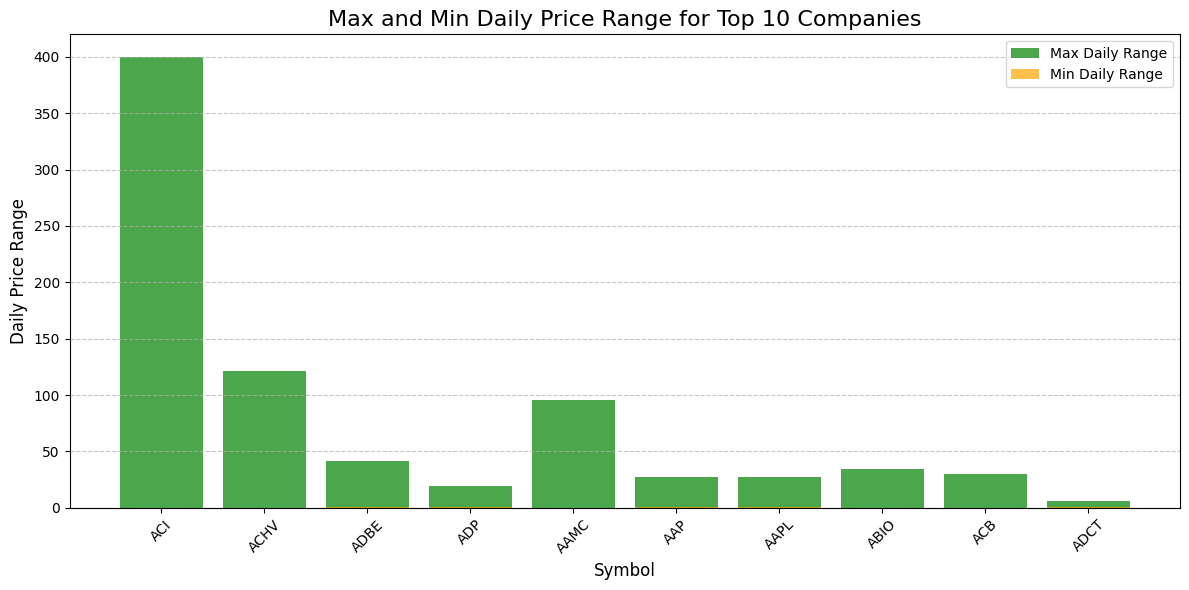

In [34]:

from pyspark.sql.functions import col, avg, max, min
import matplotlib.pyplot as plt


# Calculate daily price range (high - low)
df = df.withColumn("daily_range", col("high") - col("low"))

# Group by symbol and calculate average, max, and min daily range
daily_range_summary = df.groupBy("symbol").agg(
    avg("daily_range").alias("Avg Daily Range"),
    max("daily_range").alias("Max Daily Range"),
    min("daily_range").alias("Min Daily Range")
)

# Show the summary
daily_range_summary.show(truncate=False)

# Convert PySpark DataFrame to Pandas for visualization
pandas_daily_range = daily_range_summary.toPandas()

# Sort data for better visualization
pandas_daily_range = pandas_daily_range.sort_values(by="Avg Daily Range", ascending=False)

# Top 10 companies by Average Daily Range
top_10_daily_range = pandas_daily_range.head(10)

# Plot Top 10 Companies by Average Daily Range
plt.figure(figsize=(12, 6))
plt.bar(top_10_daily_range['symbol'], top_10_daily_range['Avg Daily Range'], color='blue', alpha=0.7)
plt.title("Top 10 Companies by Average Daily Price Range", fontsize=16)
plt.xlabel("Symbol", fontsize=12)
plt.ylabel("Average Daily Range", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Max and Min Daily Range for Top 10 Companies
plt.figure(figsize=(12, 6))
plt.bar(top_10_daily_range['symbol'], top_10_daily_range['Max Daily Range'], label="Max Daily Range", alpha=0.7, color='green')
plt.bar(top_10_daily_range['symbol'], top_10_daily_range['Min Daily Range'], label="Min Daily Range", alpha=0.7, color='orange')
plt.title("Max and Min Daily Price Range for Top 10 Companies", fontsize=16)
plt.xlabel("Symbol", fontsize=12)
plt.ylabel("Daily Price Range", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the summarized daily range data
daily_range_summary.write.csv("/content/daily_range_summary", header=True)


Cumulative Average Abnormal Return (CAAR)

In [35]:
from pyspark.sql.functions import avg, sum

df = df.withColumn("cumulative_return", sum("daily_return").over(window_spec))
df = df.withColumn("caar", avg("cumulative_return").over(Window.partitionBy("symbol")))
df.show(5)


+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+--------------------+--------------------+------------------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|        price_change|        daily_return|         daily_range|   cumulative_return|              caar|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+--------------------+--------------------+------------------+
|2019-03-11| 32100|1.0800000429153442| 1.100000023841858|1.0800000429153442|1.0800000429153442|1.0800000429153442|  AACG|                NULL|                NULL|0.019999980926513672|                NULL|1.1456593230930223|
|2019-03-12| 20200|1.0800000429153442|1.0900000333786009|1.0499999523162842|1.0499999523162842|1.049

Trends and Moving Averages

In [36]:
from pyspark.sql.functions import avg

df = df.withColumn("MA_20", avg("close").over(Window.partitionBy("symbol").orderBy("date").rowsBetween(-19, 0)))
df = df.withColumn("MA_50", avg("close").over(Window.partitionBy("symbol").orderBy("date").rowsBetween(-49, 0)))
df = df.withColumn("MA_200", avg("close").over(Window.partitionBy("symbol").orderBy("date").rowsBetween(-199, 0)))
df.show(5)


+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|        price_change|        daily_return|         daily_range|   cumulative_return|              caar|             MA_20|             MA_50|            MA_200|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+
|2019-03-11| 32100|1.0800000429153442| 1.100000023841858|1.0800000429153442|1.0800000429153442|1.0800000429153442|  AACG|                NULL|            

Correlation Analysis

            open      high       low     close    volume
open    1.000000  0.999937  0.999975  0.999933  0.023968
high    0.999937  1.000000  0.999907  0.999986  0.024372
low     0.999975  0.999907  1.000000  0.999929  0.023535
close   0.999933  0.999986  0.999929  1.000000  0.023929
volume  0.023968  0.024372  0.023535  0.023929  1.000000


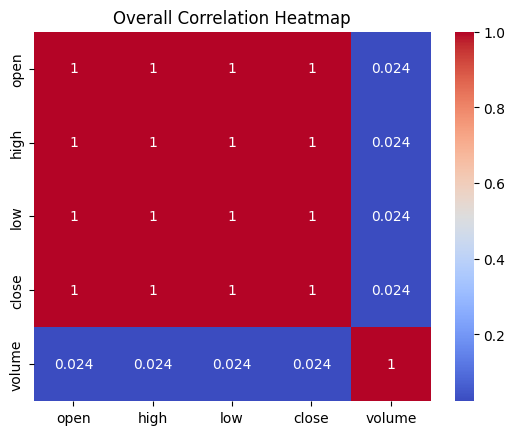

In [37]:
import seaborn as sns
from pyspark.sql import SparkSession

# Assuming 'df' is your PySpark DataFrame
pandas_df = df.toPandas()  # Convert PySpark DataFrame to Pandas DataFrame

# Overall correlation
overall_corr = pandas_df[['open', 'high', 'low', 'close', 'volume']].corr()
print(overall_corr)

# Visualize overall correlation
sns.heatmap(overall_corr, annot=True, cmap='coolwarm')
plt.title("Overall Correlation Heatmap")
plt.show()

Normalize the numeric data

In [38]:
from pyspark.sql.functions import col, min, max

# Calculate min and max for the column (e.g., "close")
stats = df.agg(
    min("close").alias("min_close"),
    max("close").alias("max_close")
).collect()[0]

min_close = stats["min_close"]
max_close = stats["max_close"]

# Apply Min-Max normalization
df = df.withColumn("normalized_close", (col("close") - min_close) / (max_close - min_close))

# Show the results
df.select("symbol", "date", "close", "normalized_close").show(10)


+------+----------+------------------+--------------------+
|symbol|      date|             close|    normalized_close|
+------+----------+------------------+--------------------+
|  AAAU|2020-07-02|17.709999084472656|0.002411110846317...|
|  AAAU|2020-07-01| 17.68000030517578|0.002406972952385179|
|  AAAU|2020-06-30|17.780000686645508|0.002420766546039...|
|  AAAU|2020-06-29| 17.68000030517578|0.002406972952385179|
|  AAAU|2020-06-26|17.670000076293945|0.002405593566710621|
|  AAAU|2020-06-25| 17.59000015258789|0.002394558744405...|
|  AAAU|2020-06-24|17.610000610351562|0.002397317515754188|
|  AAAU|2020-06-23| 17.65999984741211|0.002404214181036...|
|  AAAU|2020-06-22|              17.5|0.002382144536424...|
|  AAAU|2020-06-19|17.399999618530273|0.002368350942770299|
+------+----------+------------------+--------------------+
only showing top 10 rows



In [39]:
# Check the schema of the dataset
df.printSchema()

# List all numeric columns
numeric_cols = [field.name for field in df.schema.fields if str(field.dataType) in ['DoubleType', 'IntegerType', 'FloatType']]
print("Numeric columns:", numeric_cols)


root
 |-- date: date (nullable = true)
 |-- volume: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price_change: double (nullable = true)
 |-- daily_return: double (nullable = true)
 |-- daily_range: double (nullable = true)
 |-- cumulative_return: double (nullable = true)
 |-- caar: double (nullable = true)
 |-- MA_20: double (nullable = true)
 |-- MA_50: double (nullable = true)
 |-- MA_200: double (nullable = true)
 |-- normalized_close: double (nullable = true)

Numeric columns: []


In [40]:
# Check the schema of the dataset
df.printSchema()

# Identify numeric columns
numeric_cols = [field.name for field in df.schema.fields if str(field.dataType) in ['DoubleType', 'IntegerType', 'FloatType']]
print("Numeric columns:", numeric_cols)


root
 |-- date: date (nullable = true)
 |-- volume: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price_change: double (nullable = true)
 |-- daily_return: double (nullable = true)
 |-- daily_range: double (nullable = true)
 |-- cumulative_return: double (nullable = true)
 |-- caar: double (nullable = true)
 |-- MA_20: double (nullable = true)
 |-- MA_50: double (nullable = true)
 |-- MA_200: double (nullable = true)
 |-- normalized_close: double (nullable = true)

Numeric columns: []


In [41]:
numeric_cols = ["volume", "open", "high", "low", "close", "adjclose", "daily_return", "cumulative_return", "caar"]
print("Numeric columns:", numeric_cols)


Numeric columns: ['volume', 'open', 'high', 'low', 'close', 'adjclose', 'daily_return', 'cumulative_return', 'caar']


In [42]:
def compute_numeric_stats(data):
    """Compute descriptive statistics for numeric columns."""
    # Select numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    # Compute statistics
    stats = numeric_data.describe()
    return stats


# Compute descriptive statistics
numeric_stats = data.describe()

# Save the statistics to a CSV file
output_path = "/content/descriptive_statistics.csv"
# Changed stats to numeric_stats and call to_csv on the Pandas DataFrame
numeric_stats.to_csv(output_path, index=True)

print(f"Descriptive statistics saved to {output_path}")

Descriptive statistics saved to /content/descriptive_statistics.csv


In [ ]:
def compute_numeric_stats(data):
    """Compute descriptive statistics for numeric columns."""
    # Select numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    # Compute statistics
    stats = numeric_data.describe()
    return stats


# Compute descriptive statistics
numeric_stats = data.describe()

# Save the statistics to a CSV file
output_path = "/content/descriptive_statistics.csv"
# Changed stats to numeric_stats and call to_csv on the Pandas DataFrame
numeric_stats.to_csv(output_path, index=True)

print(f"Descriptive statistics saved to {output_path}")

Descriptive statistics saved to /content/descriptive_statistics.csv


Data Convertion

## Analysis

## Descriptive summary

Summative Analysis

In [43]:
df.select("close").describe().show()


+-------+-------------------+
|summary|              close|
+-------+-------------------+
|  count|              96163|
|   mean|  52.74589105208757|
| stddev| 273.35235974253277|
|    min|0.23000000417232516|
|    max|             7250.0|
+-------+-------------------+



In [44]:
df.describe().show()

+-------+-----------------+------------------+-----------------+-------------------+-------------------+-------------------+------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+
|summary|           volume|              open|             high|                low|              close|           adjclose|symbol|        price_change|        daily_return|       daily_range|  cumulative_return|               caar|             MA_20|             MA_50|            MA_200|    normalized_close|
+-------+-----------------+------------------+-----------------+-------------------+-------------------+-------------------+------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+
|  count|            96163|             96163|            96163|   

Group by Company (Symbol)

In [45]:
from pyspark.sql.functions import avg, max, min

company_summary = df.groupBy("symbol").agg(
    avg("close").alias("avg_close"),
    max("close").alias("max_close"),
    min("close").alias("min_close"),
    avg("volume").alias("avg_volume")
)
company_summary.show()


+------+------------------+------------------+-------------------+--------------------+
|symbol|         avg_close|         max_close|          min_close|          avg_volume|
+------+------------------+------------------+-------------------+--------------------+
|   AAT|40.320707549773395|48.959999084472656| 21.479999542236328|   260853.2129963899|
|  ACCO| 9.801465703089745|14.699999809265135|  3.890000104904175|   605186.8592057761|
|   ACH|10.721523456366914| 23.45000076293945| 4.6599998474121085|   74707.14801444043|
|  AAPL|168.10501793265772| 366.5299987792969|  90.33999633789062| 3.653794259927798E7|
| ACGLO| 24.52429222730388|26.687000274658203| 16.809999465942386|   45098.19944598338|
|  AAMC| 57.19272523590746| 342.8500061035156|  7.989999771118164|  12919.476520400309|
|   ACA|35.647625888851906| 47.66999816894531|   23.1200008392334|   391995.6834532374|
|   ABM| 35.40301080008276|44.790000915527344| 20.450000762939453|  415438.70036101085|
| ACGLP|23.737268401698064|26.04

## Analysis

## **1** Explore Price Trends and Behaviors for Each Company Over Time

Filter Relevant Features for Analysis

In [46]:
relevant_columns = ['date', 'open', 'high', 'low', 'close', 'volume']
filtered_df = df.select(relevant_columns)
filtered_df.show(5)


+----------+------------------+------------------+------------------+------------------+------+
|      date|              open|              high|               low|             close|volume|
+----------+------------------+------------------+------------------+------------------+------+
|2020-07-02|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|257500|
|2020-07-01|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578|468100|
|2020-06-30|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|319100|
|2020-06-29|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578|405500|
|2020-06-26|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|335100|
+----------+------------------+------------------+------------------+------------------+------+
only showing top 5 rows



Trend Analysis

In [47]:
from pyspark.sql.functions import window

trend_df = df.groupBy("symbol", window("date", "30 days")).agg(avg("close").alias("avg_close"))
trend_df.show()


+------+--------------------+------------------+
|symbol|              window|         avg_close|
+------+--------------------+------------------+
|  AAMC|{2017-07-23 00:00...|  84.4395243326823|
|  AAON|{2018-11-15 00:00...| 37.16849994659424|
|  AAPL|{2015-09-02 00:00...|112.88619014195034|
|   AAT|{2017-08-22 00:00...| 40.45952370053246|
|  ABCB|{2015-04-05 00:00...| 25.81142843337286|
|  ABIO|{2020-01-09 00:00...| 5.706666651226225|
|   ACB|{2019-02-13 00:00...| 91.09142812093098|
|   ACC|{2015-02-04 00:00...|42.503809429350355|
|  ACCO|{2018-07-18 00:00...|13.163636424324729|
|  ACER|{2016-07-28 00:00...| 44.01041672446511|
|  ACHV|{2015-10-02 00:00...|241.05714271182106|
|  ACIU|{2018-02-18 00:00...|11.329499912261962|
|  ACIW|{2018-03-20 00:00...|24.310952231997536|
|  ACRE|{2017-11-20 00:00...|13.389523733229865|
|   AAL|{2019-09-11 00:00...|27.439545544711027|
|   AAN|{2017-12-20 00:00...|40.280526412160775|
|   AAP|{2018-08-17 00:00...|164.34799880981444|
|  ABCB|{2019-03-15 

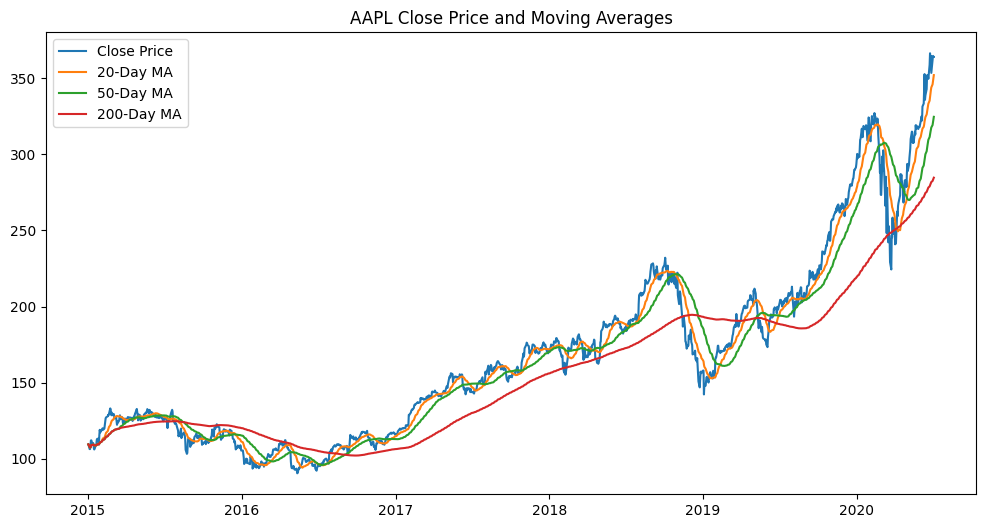

In [48]:
pandas_df = df.toPandas()

import matplotlib.pyplot as plt
company = "AAPL"
firm_data = pandas_df[pandas_df["symbol"] == company]
plt.figure(figsize=(12, 6))
plt.plot(firm_data["date"], firm_data["close"], label="Close Price")
plt.plot(firm_data["date"], firm_data["MA_20"], label="20-Day MA")
plt.plot(firm_data["date"], firm_data["MA_50"], label="50-Day MA")
plt.plot(firm_data["date"], firm_data["MA_200"], label="200-Day MA")
plt.legend()
plt.title(f"{company} Close Price and Moving Averages")
plt.show()


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Step 1: Read all CSV files from the `/content` directory
file_path = '/content/data/'  # Update this if the files are in another directory
all_files = glob.glob(file_path + "*.csv")

# Combine all files into a single Pandas DataFrame
dataframes = [pd.read_csv(f) for f in all_files]
pandas_df = pd.concat(dataframes, ignore_index=True)

# Ensure the date column is in datetime format
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

# Step 2: Filter data for a specific company (e.g., "AAPL")
company = "AAPL"  # Replace with the desired company symbol
firm_data = pandas_df[pandas_df["symbol"] == company]

# Ensure the data is sorted by date for proper time-series plotting
firm_data = firm_data.sort_values(by="date")

# Step 3: Plot Close Price and Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(firm_data["date"], firm_data["close"], label="Close Price")
plt.plot(firm_data["date"], firm_data["MA_20"], label="20-Day MA")
plt.plot(firm_data["date"], firm_data["MA_50"], label="50-Day MA")
plt.plot(firm_data["date"], firm_data["MA_200"], label="200-Day MA")
plt.legend()
plt.title(f"{company} Close Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os

# Step 1: Read all CSV files from the correct directory
file_path = '/content/'  # Corrected file path
all_files = glob.glob(os.path.join(file_path, "*.csv"))  # Use os.path.join for platform compatibility

if not all_files:
    print("Warning: No CSV files found in the directory. Check the file path.")

# Combine all files into a single Pandas DataFrame
dataframes = [pd.read_csv(f) for f in all_files if f.endswith('.csv')]  # Add condition to ensure only CSV files are read
pandas_df = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()  # Handle empty dataframes

# Rest of the code remains the same...

In [49]:
# Convert PySpark DataFrame to Pandas
pandas_df = df.toPandas()

# Ensure `Date` column is in datetime format for better handling
pandas_df['date'] = pandas_df['date'].astype('datetime64[ns]')



In [50]:
from pyspark.sql.functions import corr # Import the corr function

df.select(corr("close", "volume").alias("correlation")).show()

+--------------------+
|         correlation|
+--------------------+
|0.023929097733127458|
+--------------------+



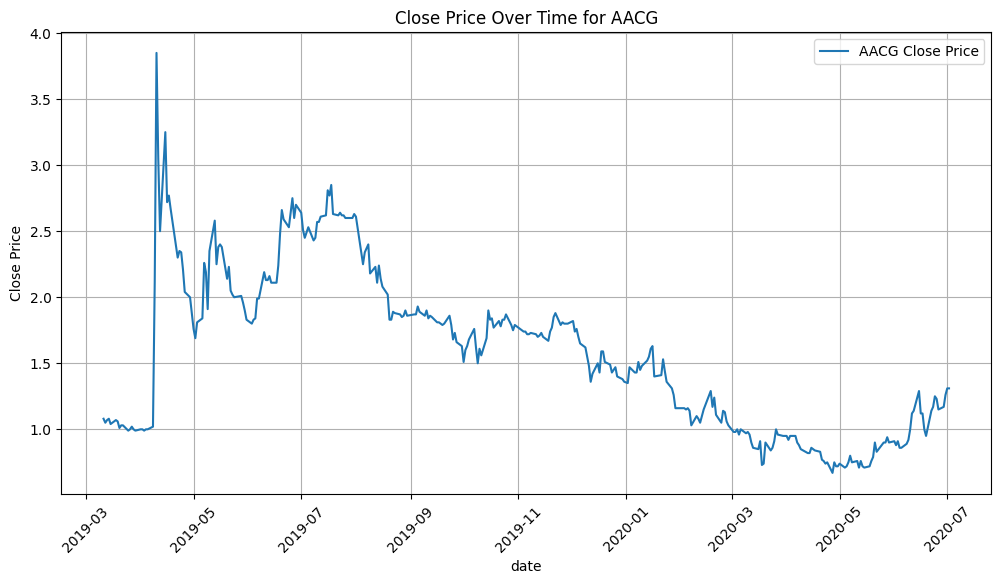

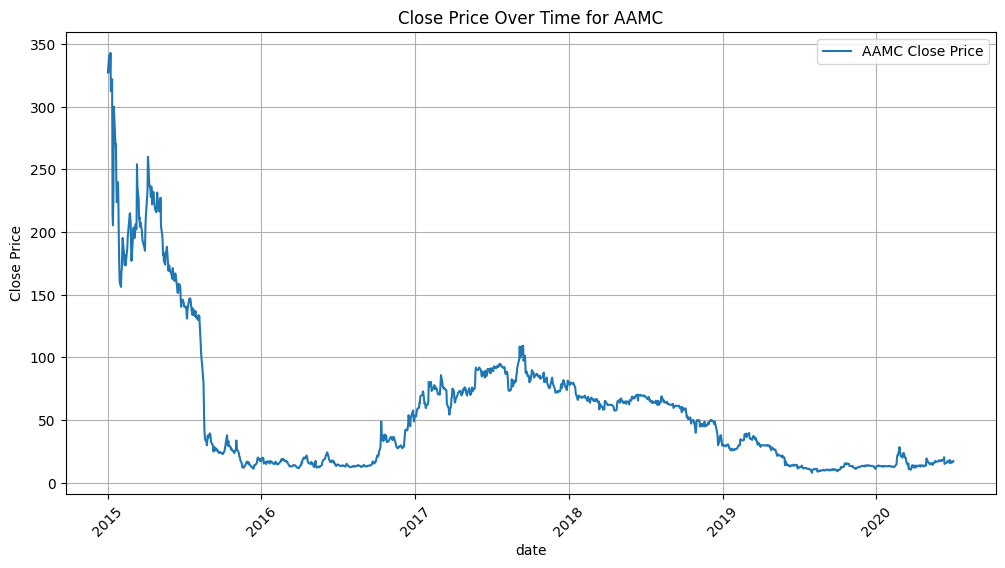

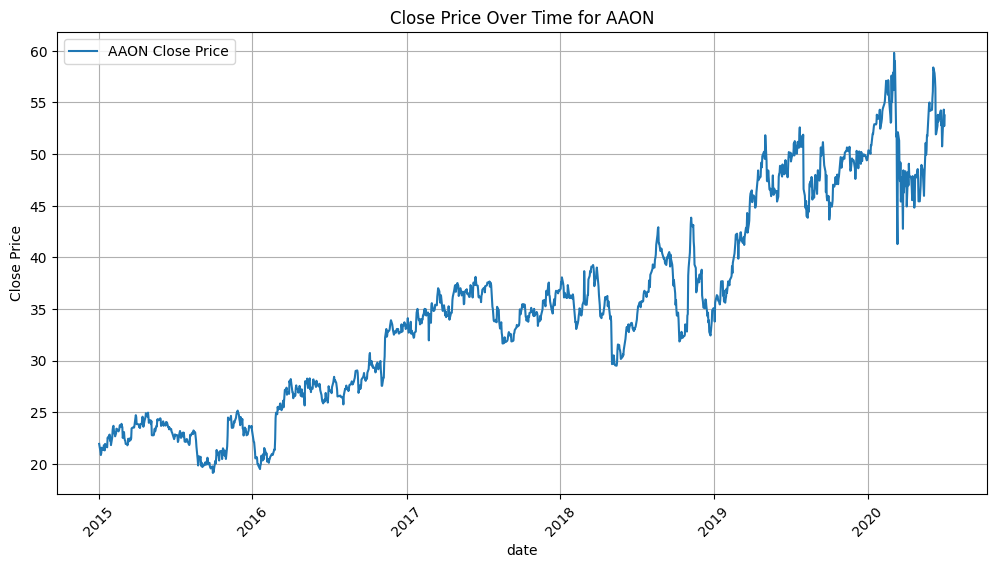

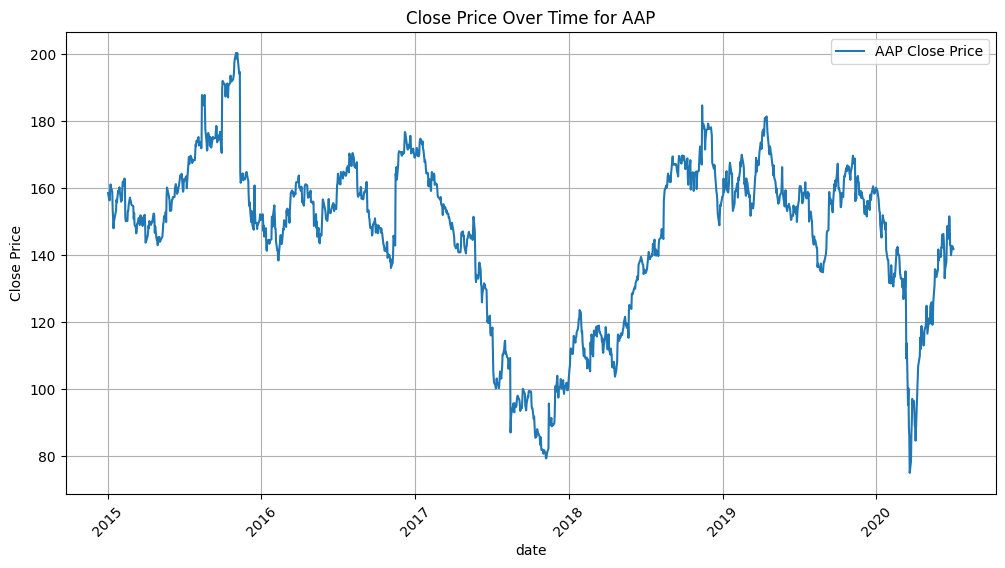

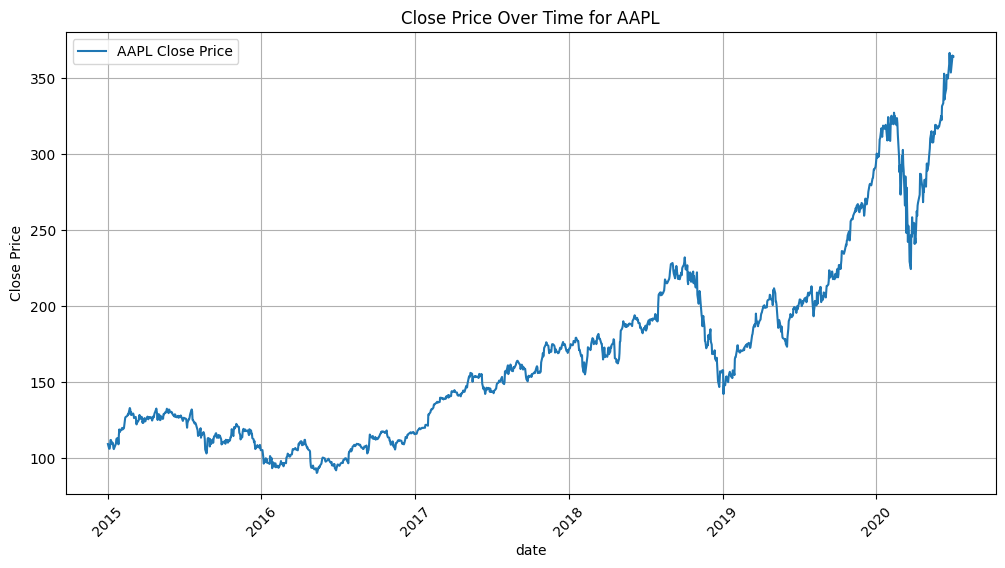

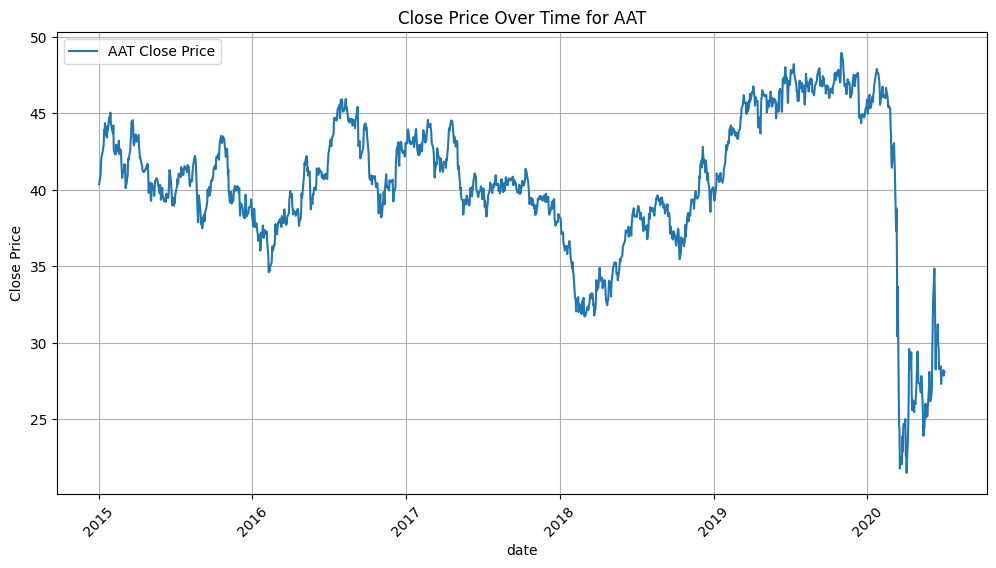

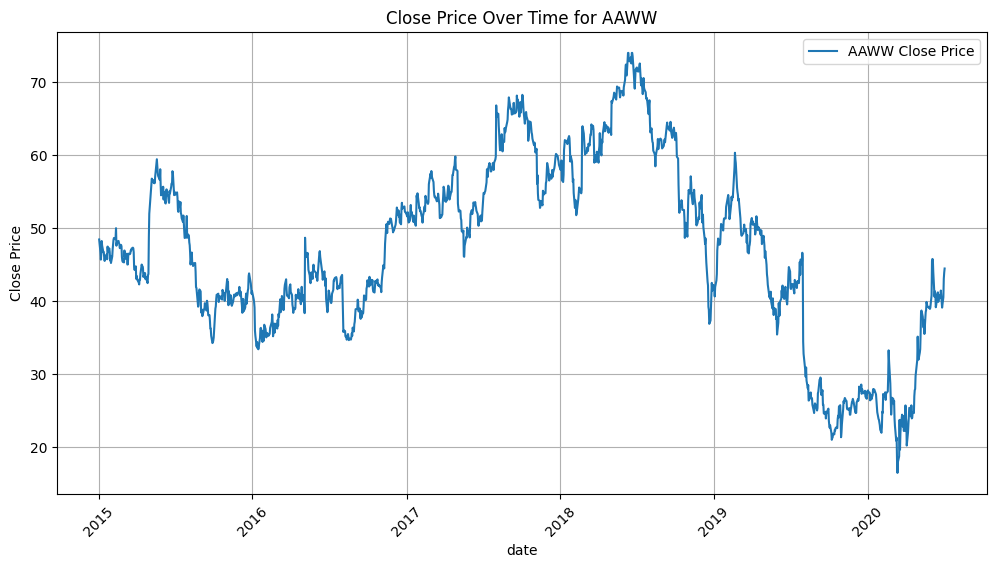

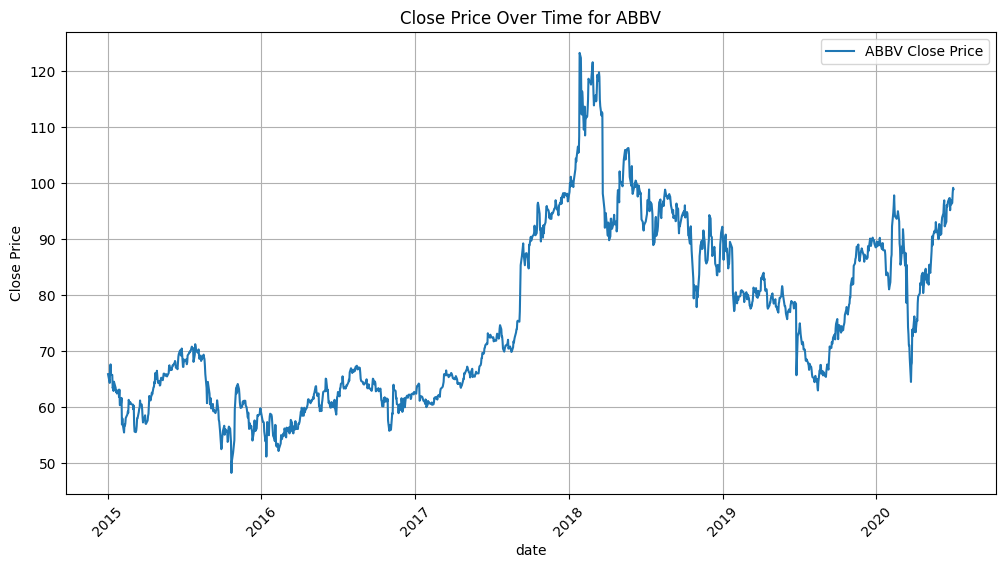

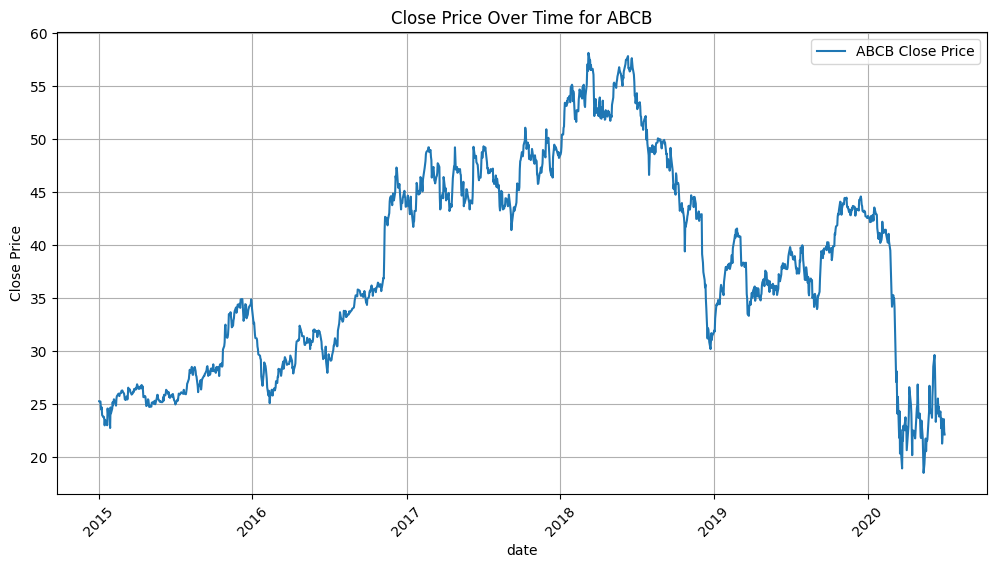

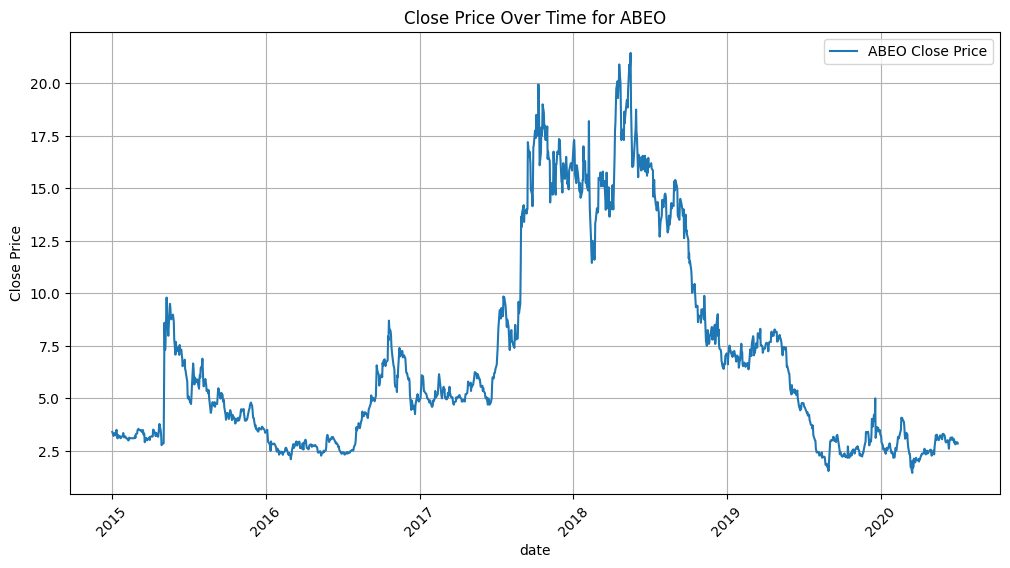

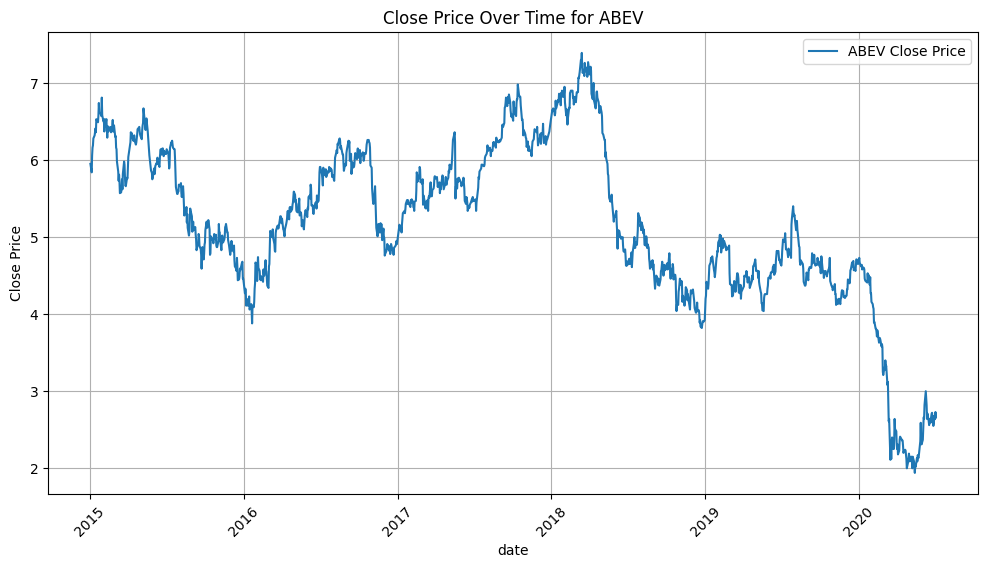

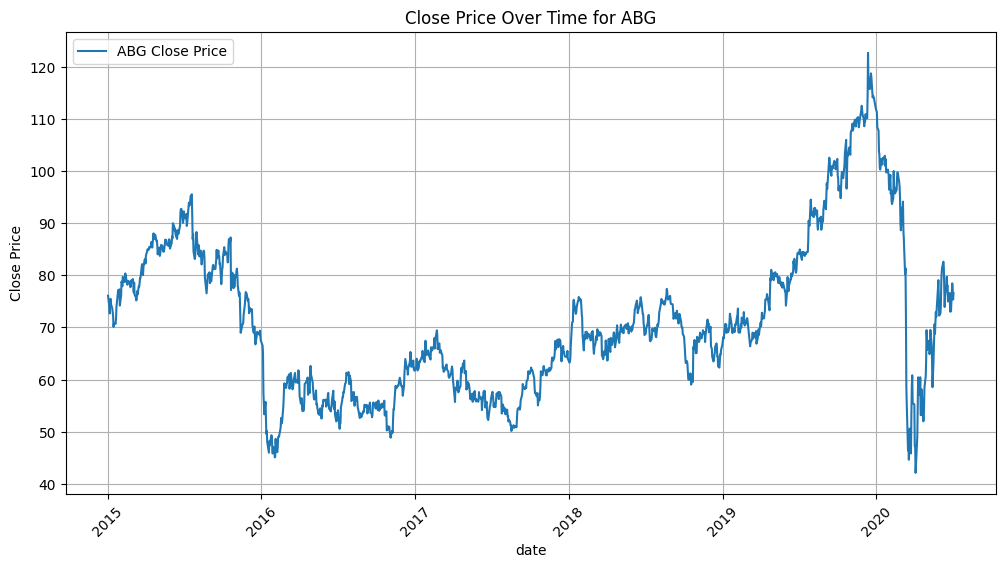

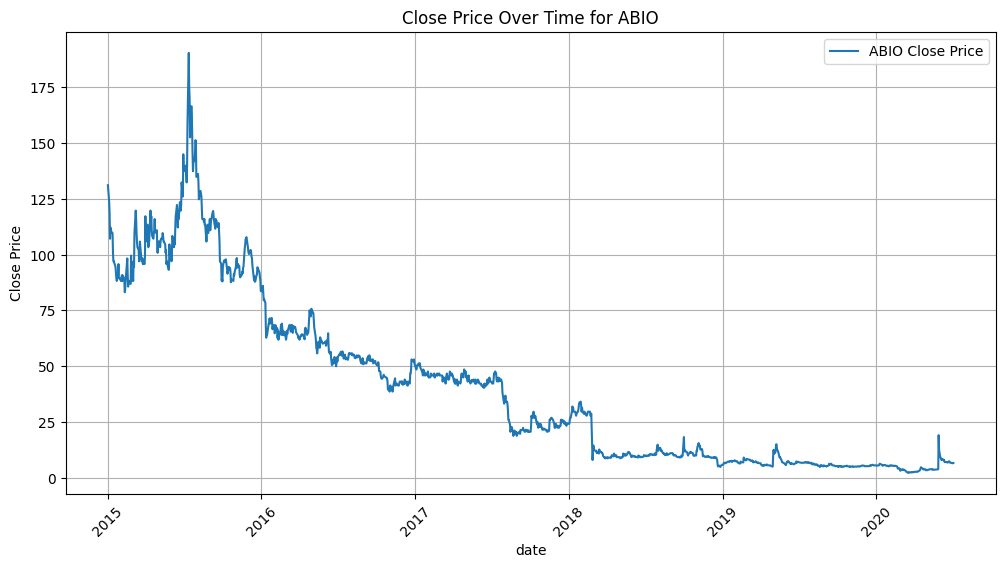

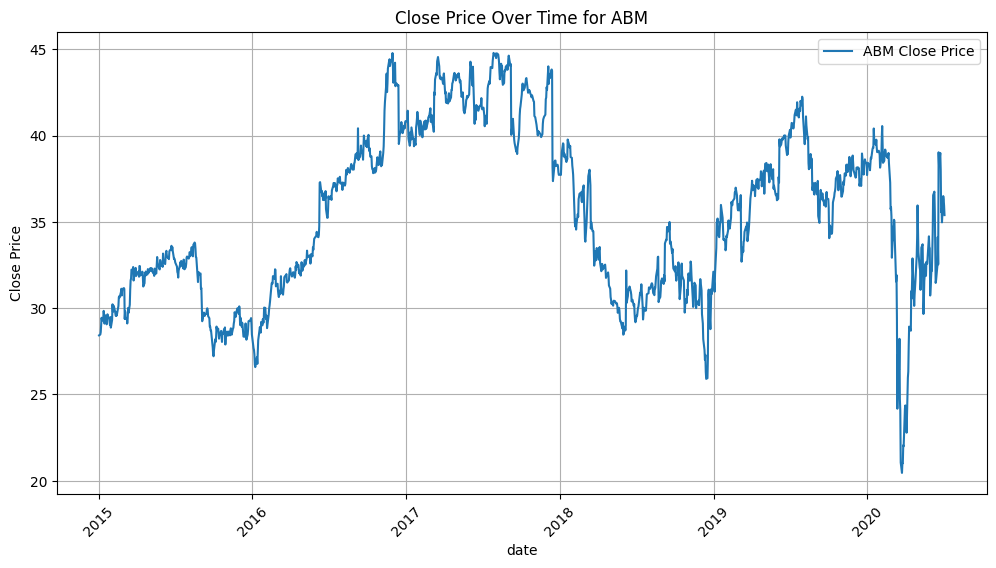

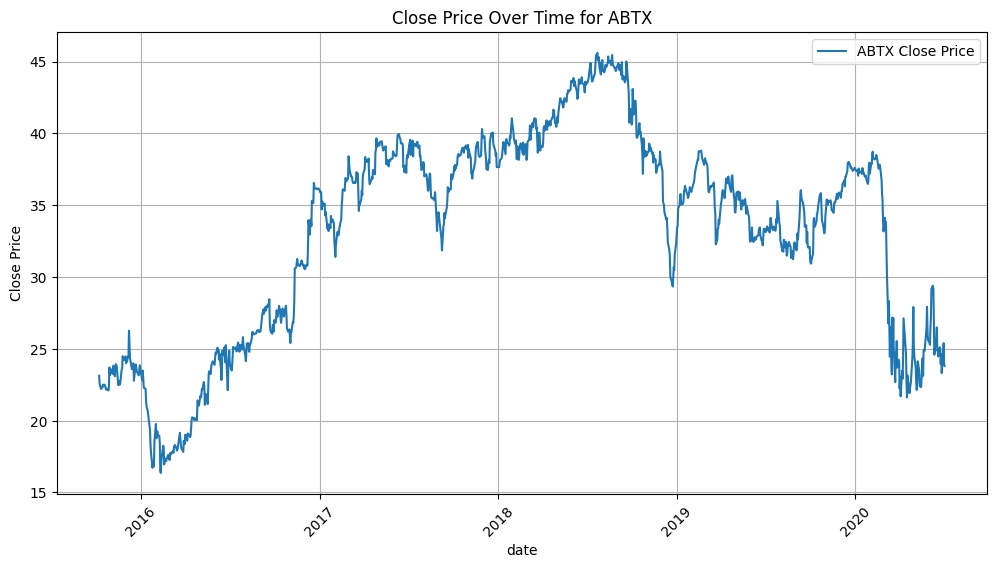

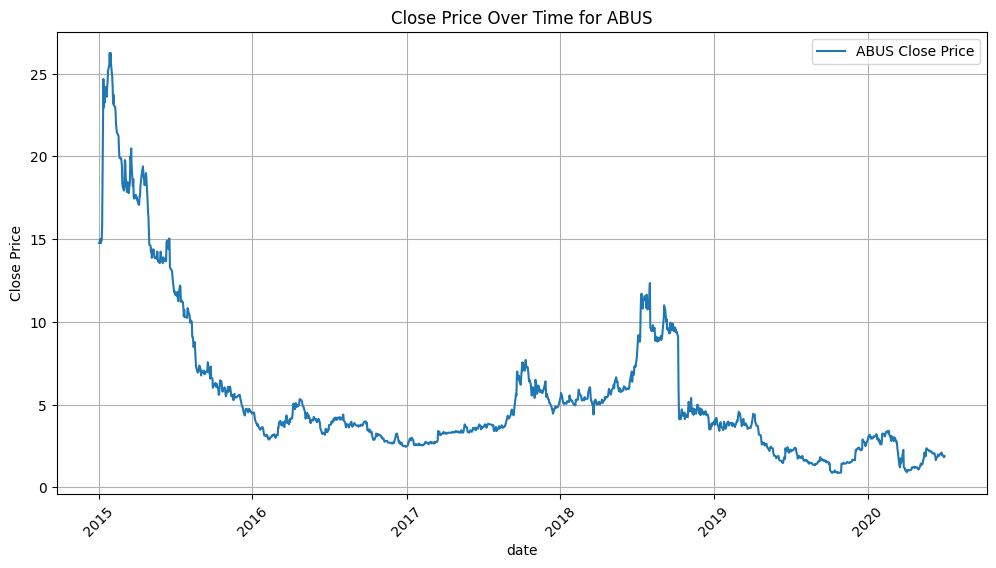

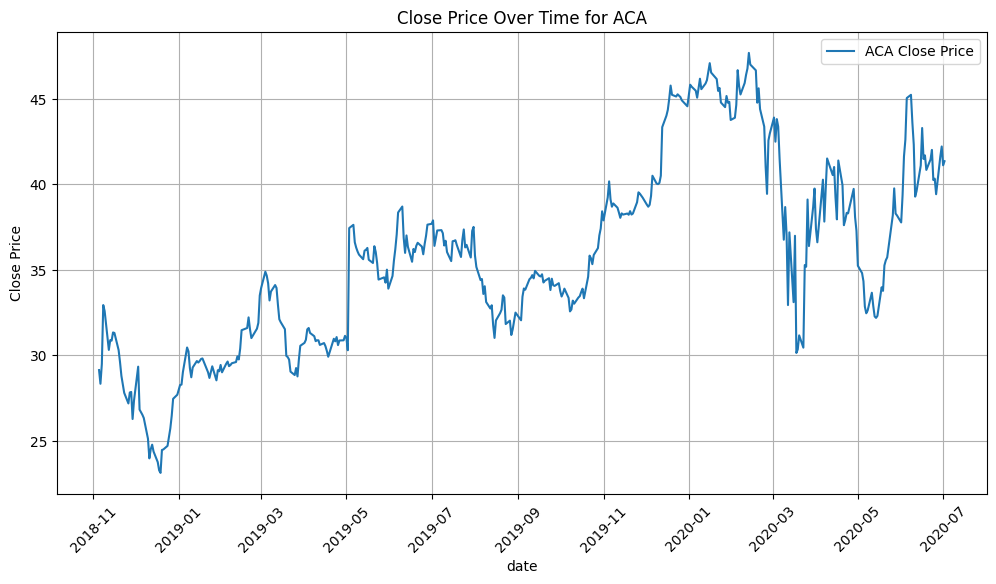

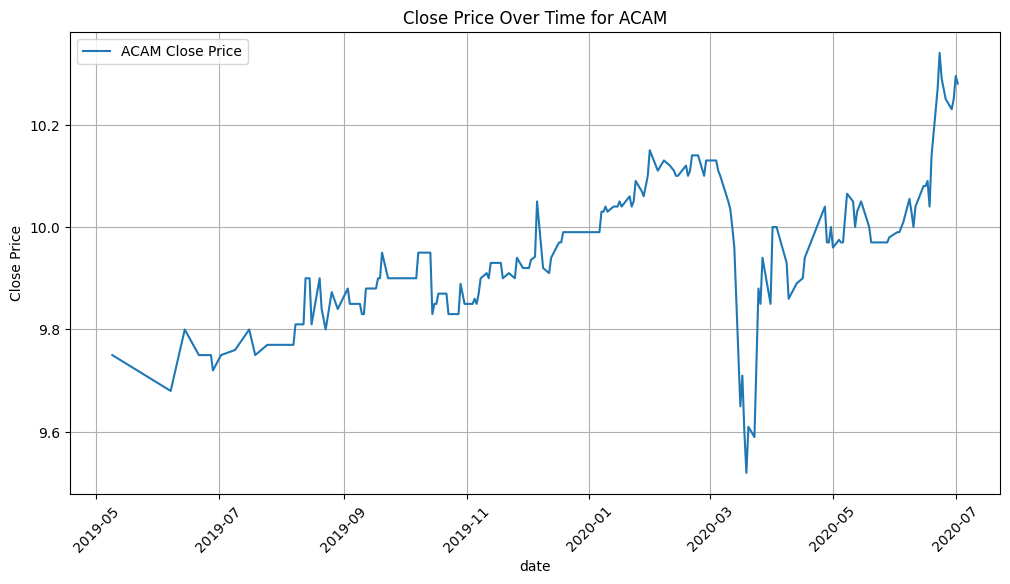

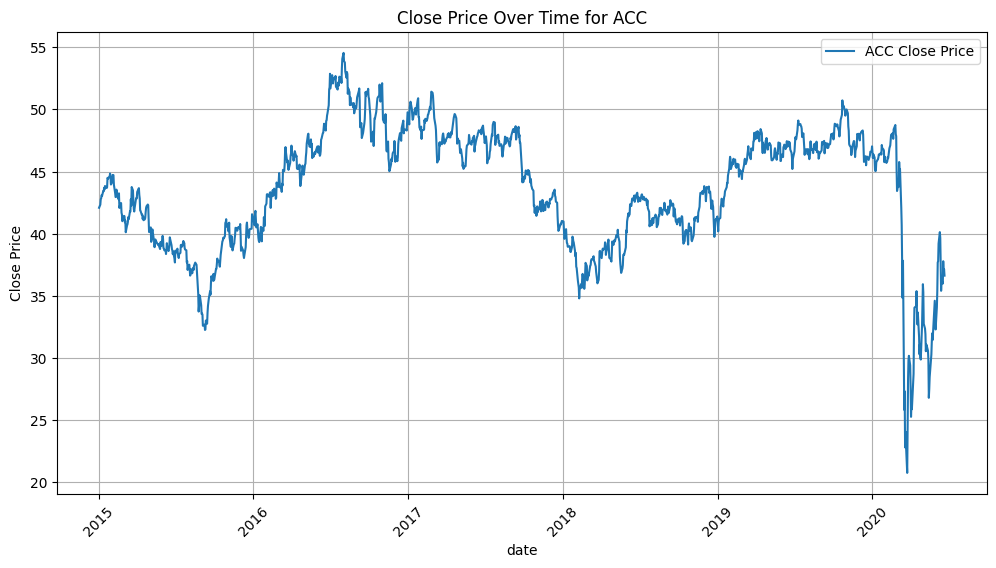

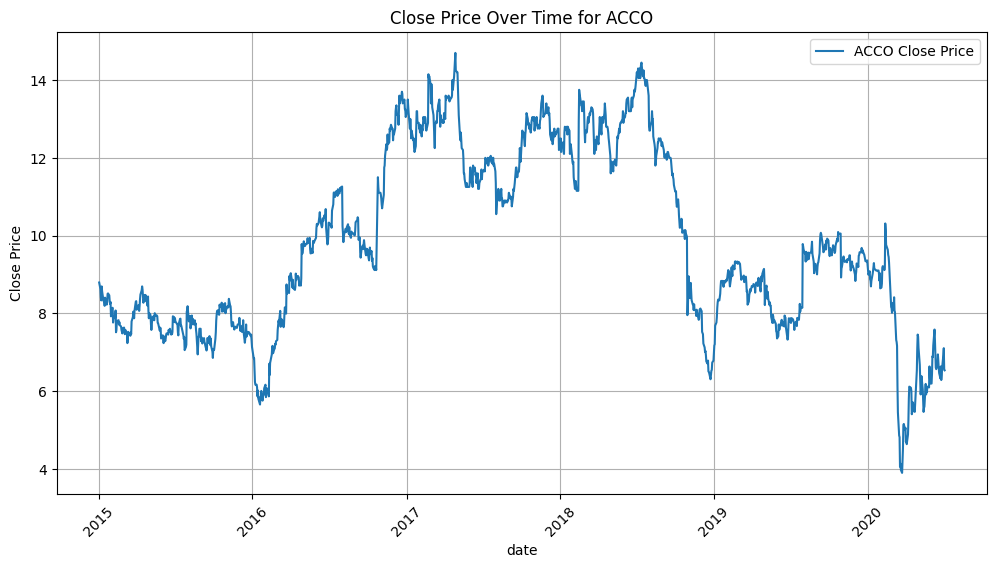

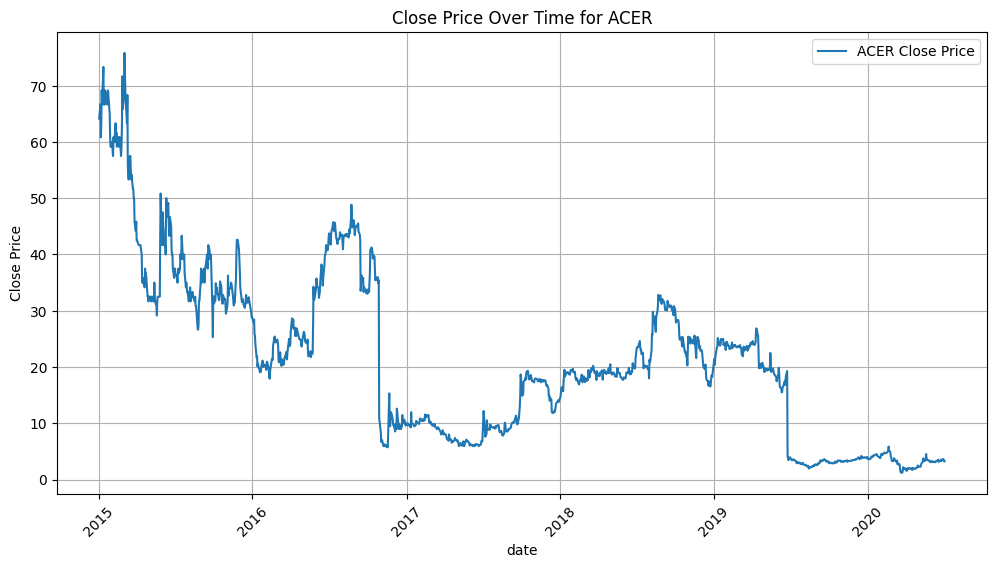

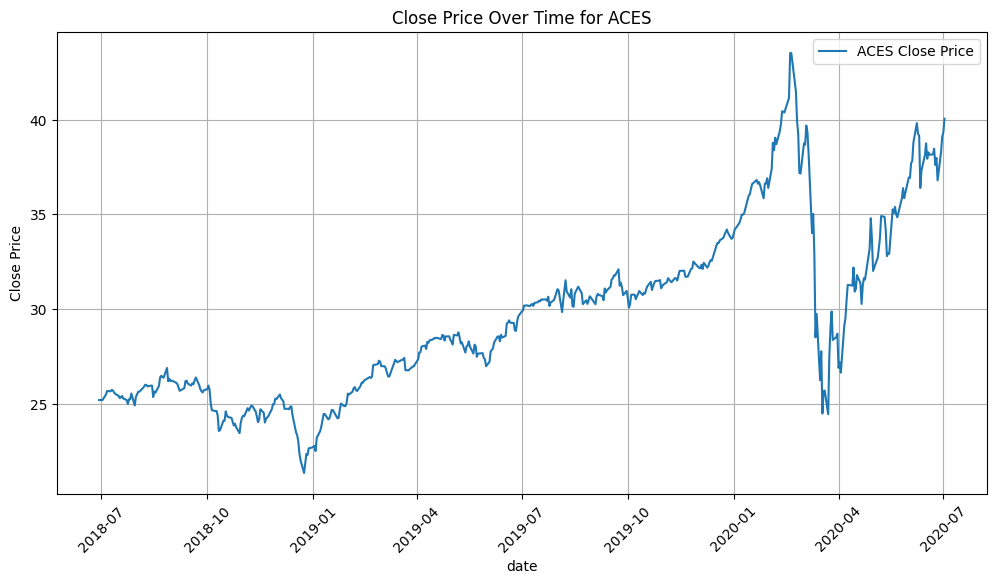

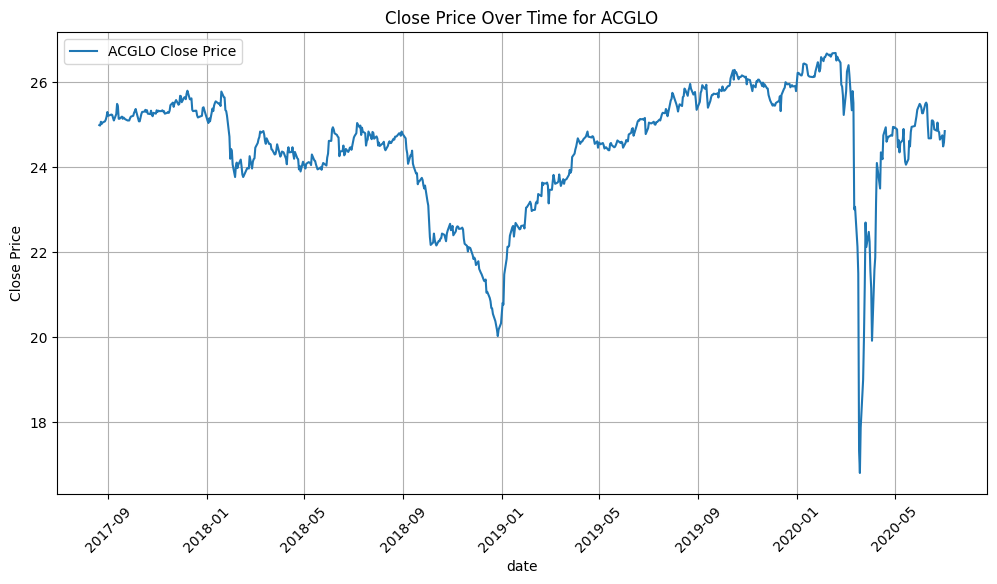

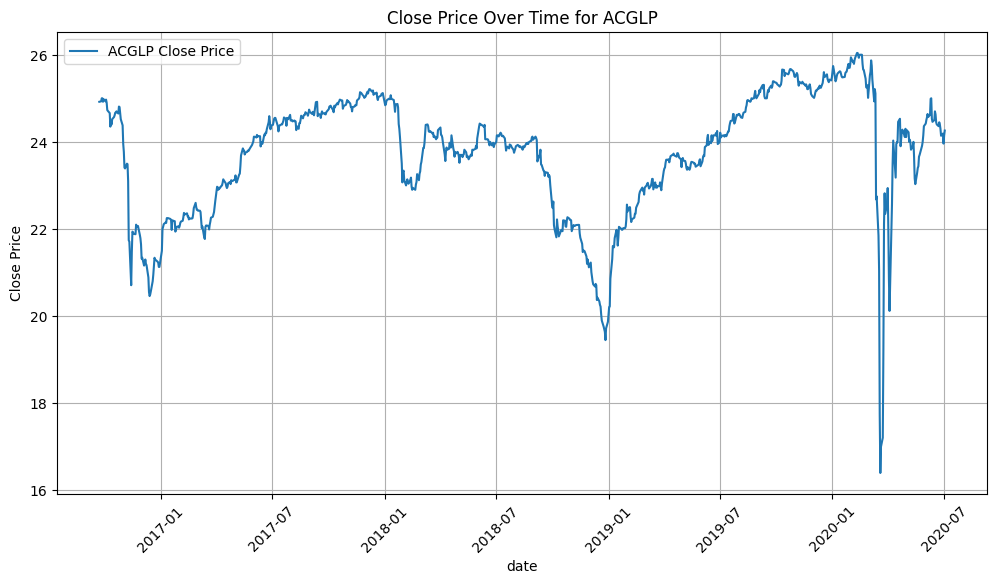

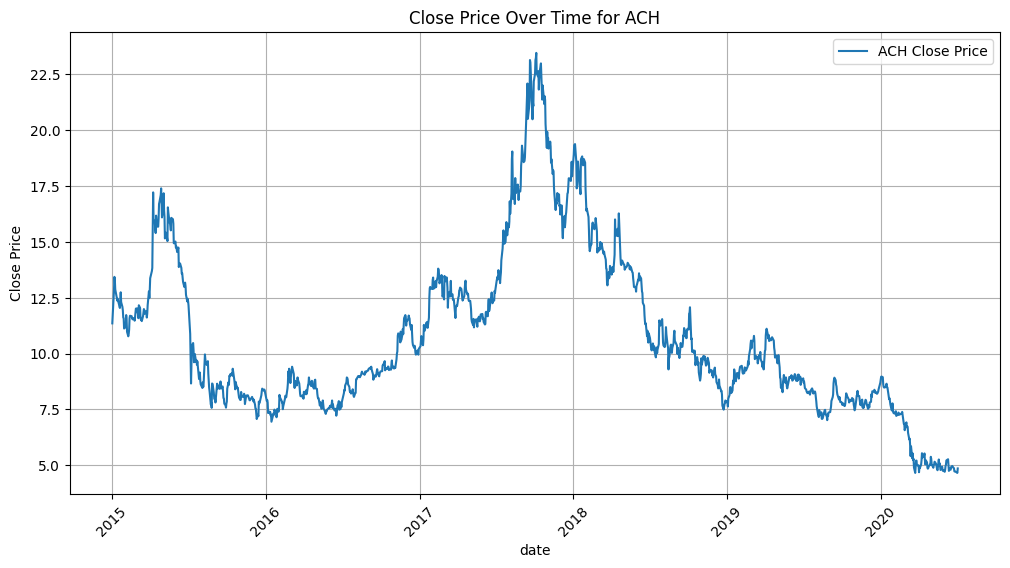

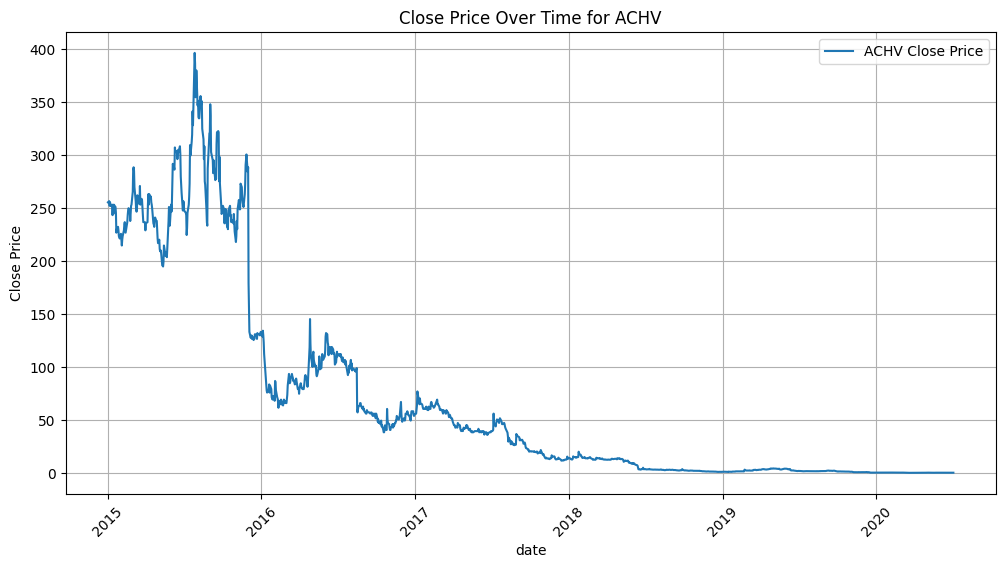

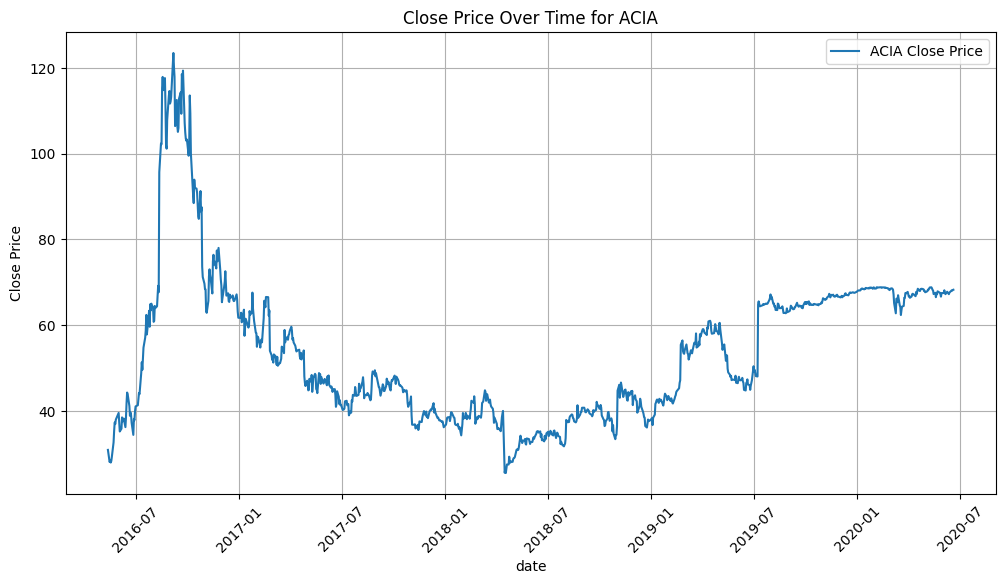

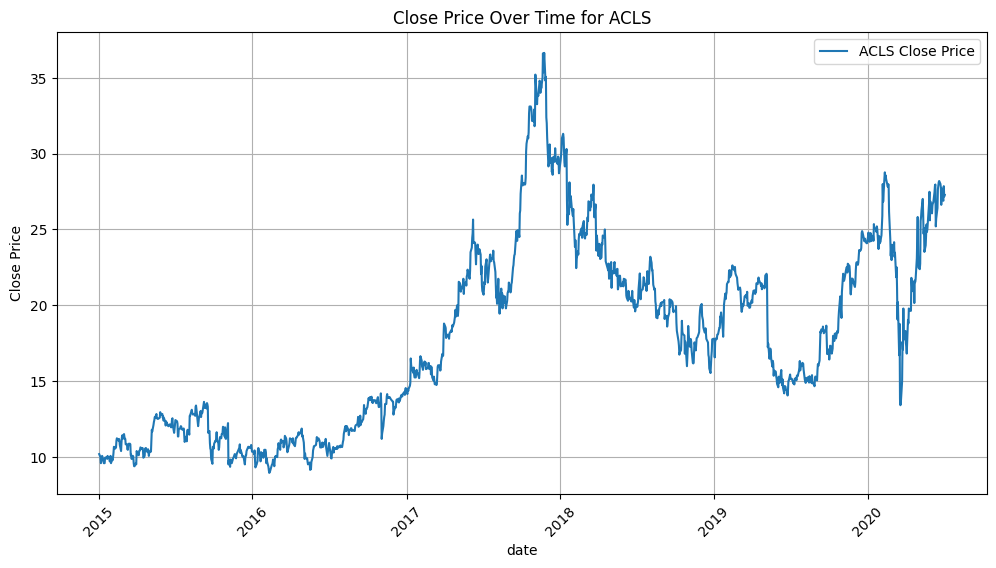

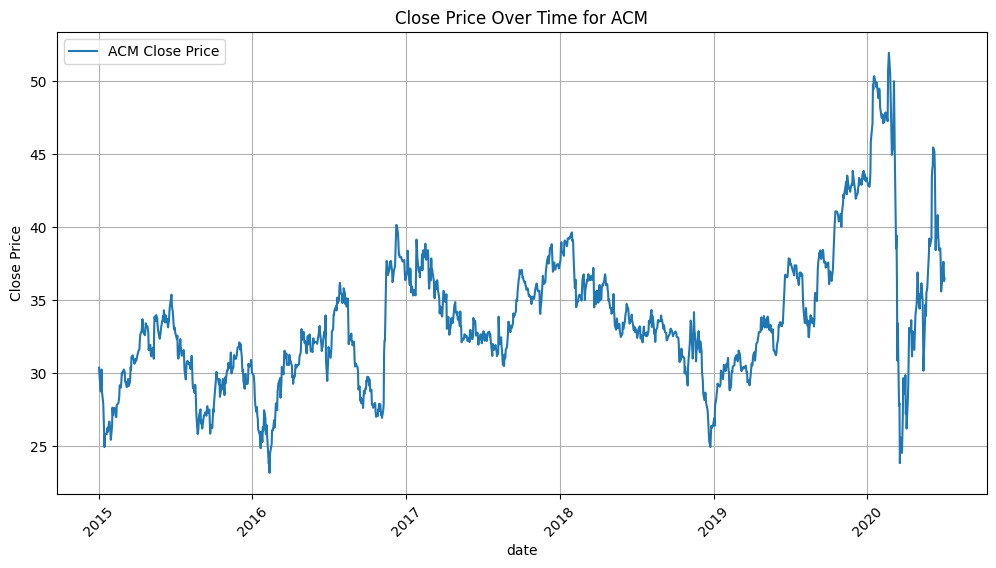

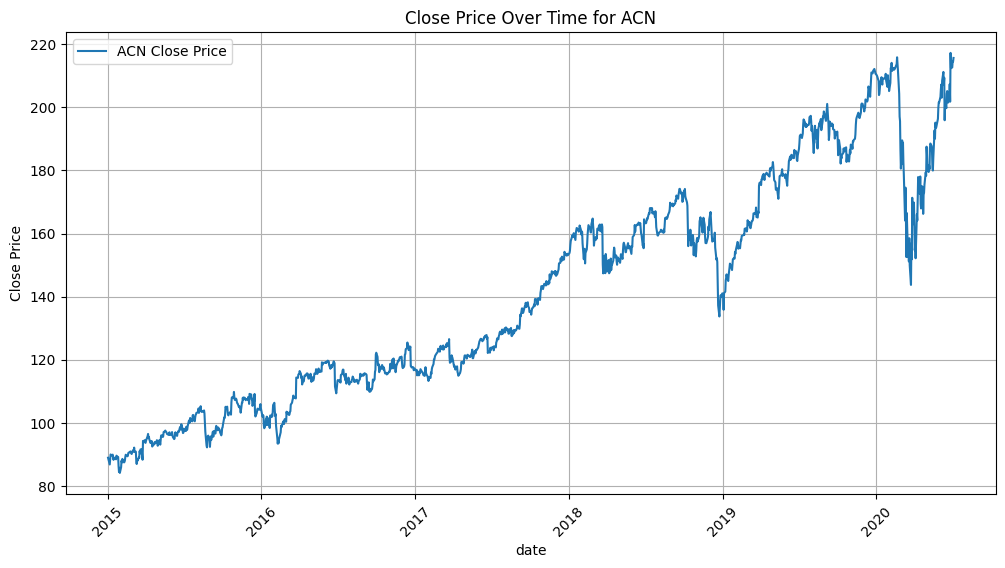

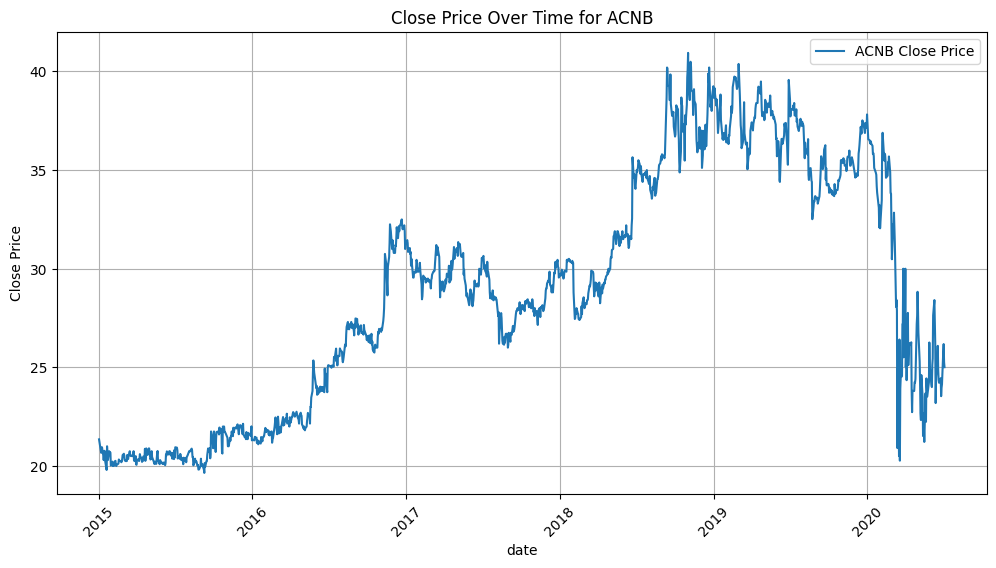

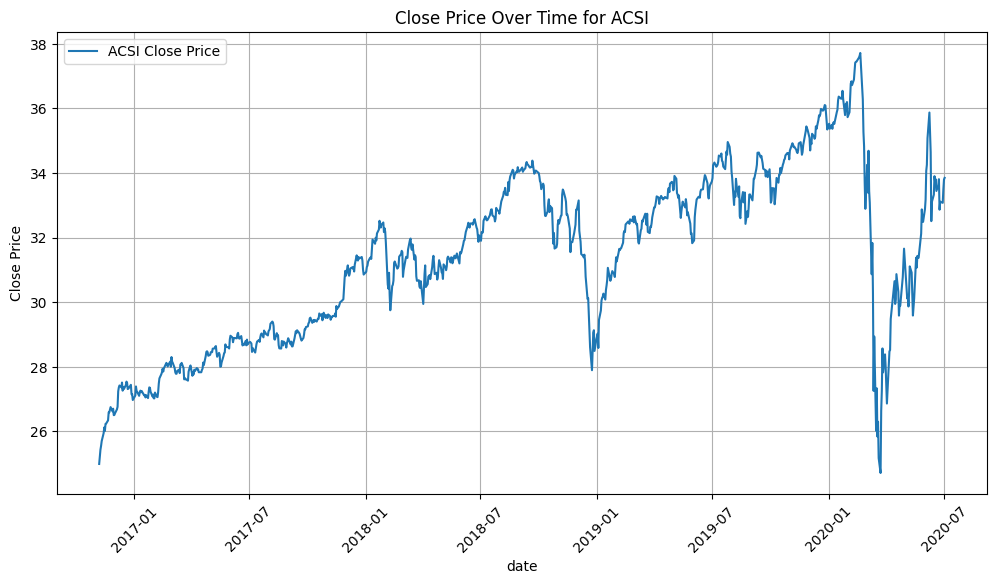

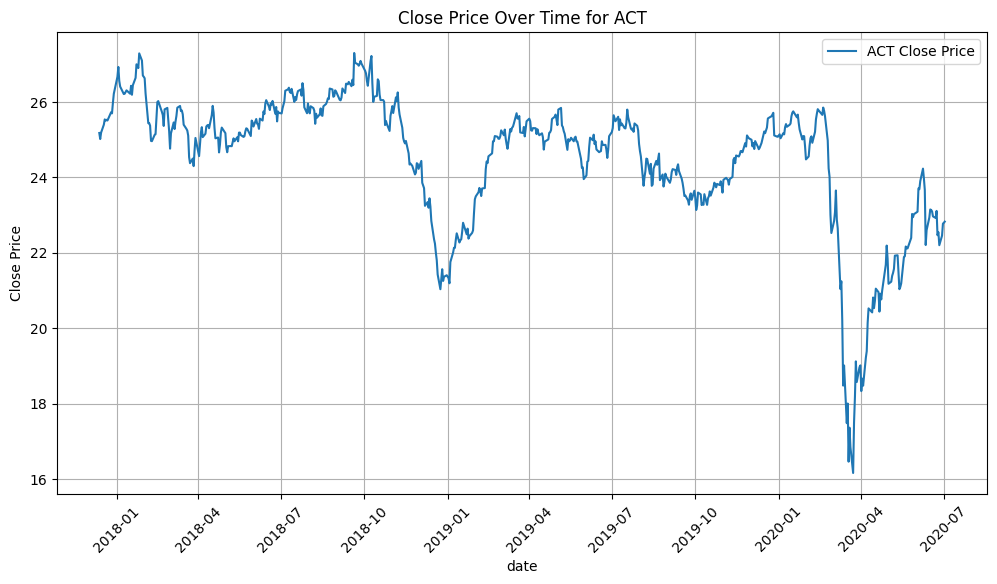

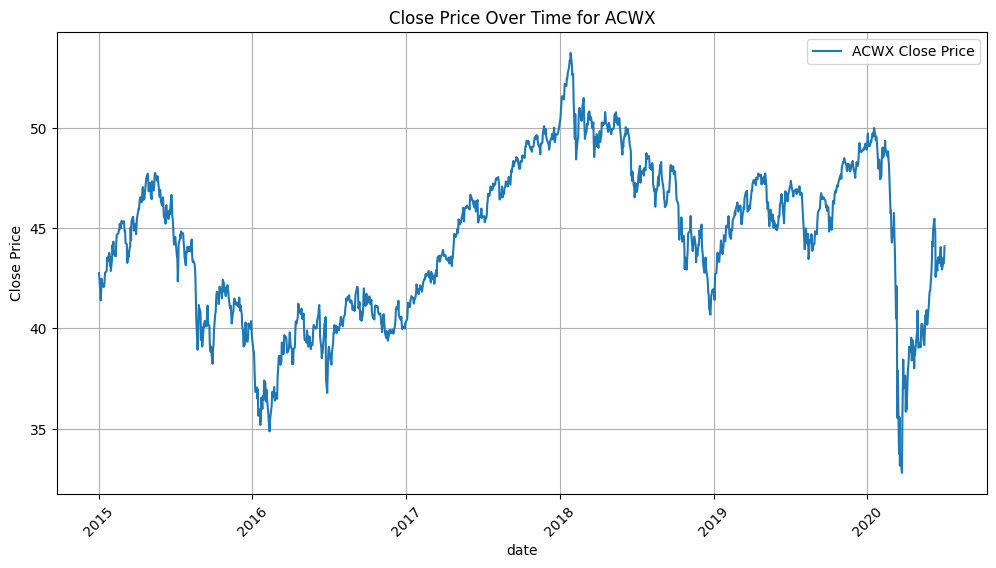

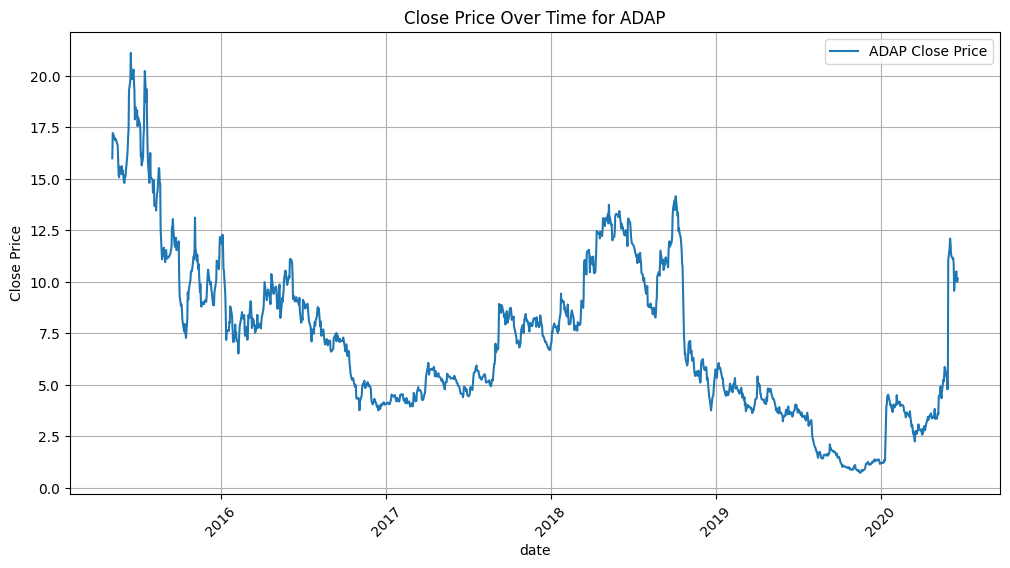

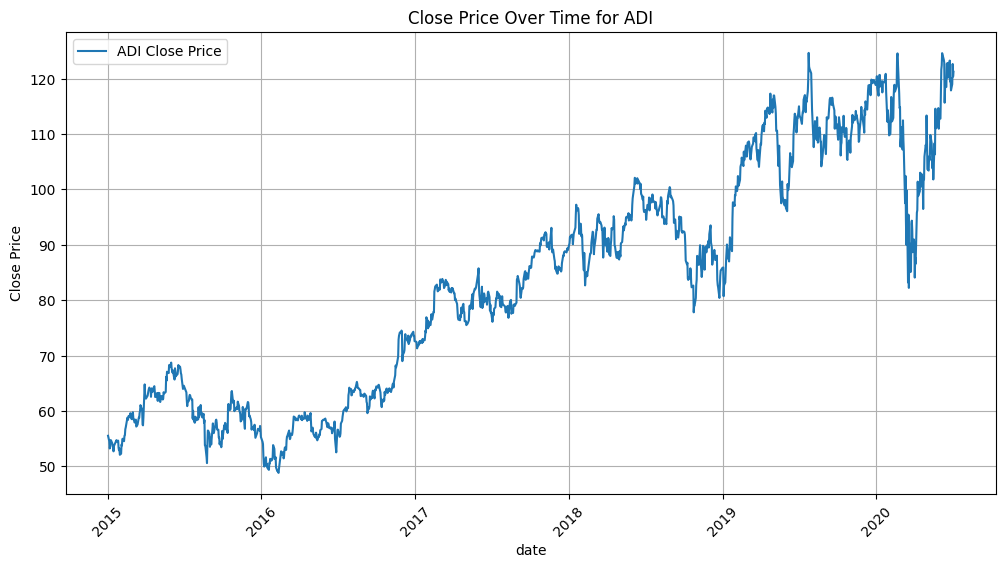

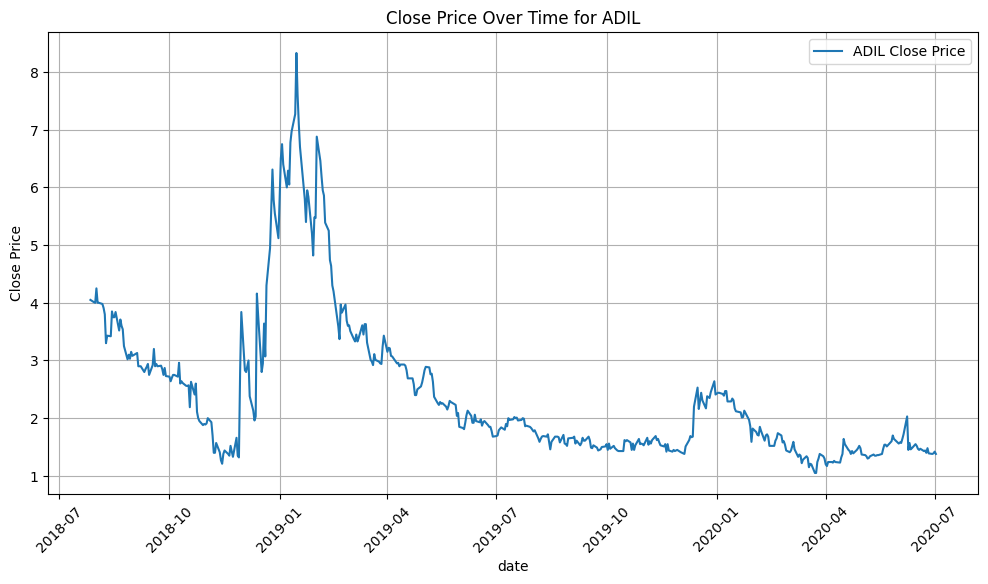

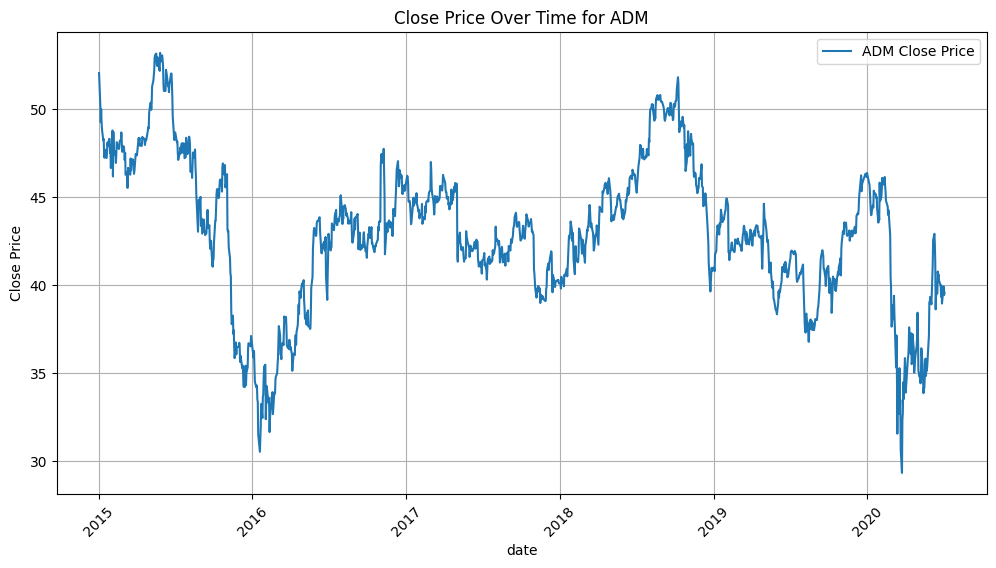

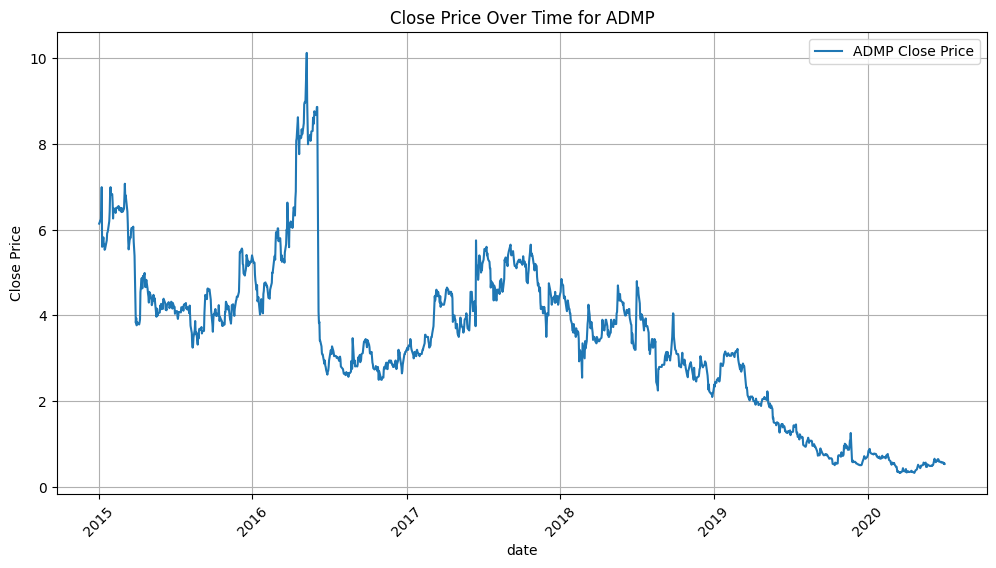

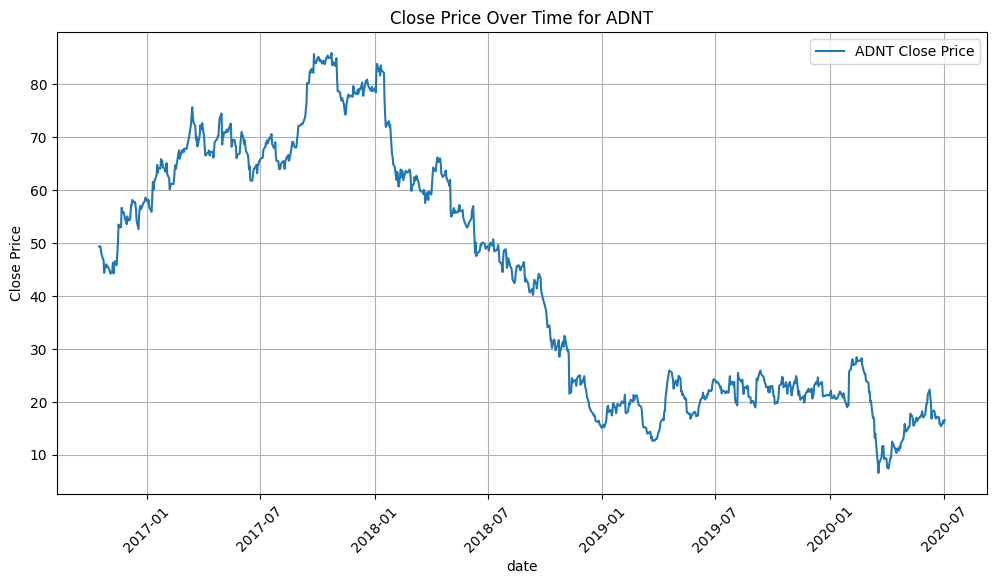

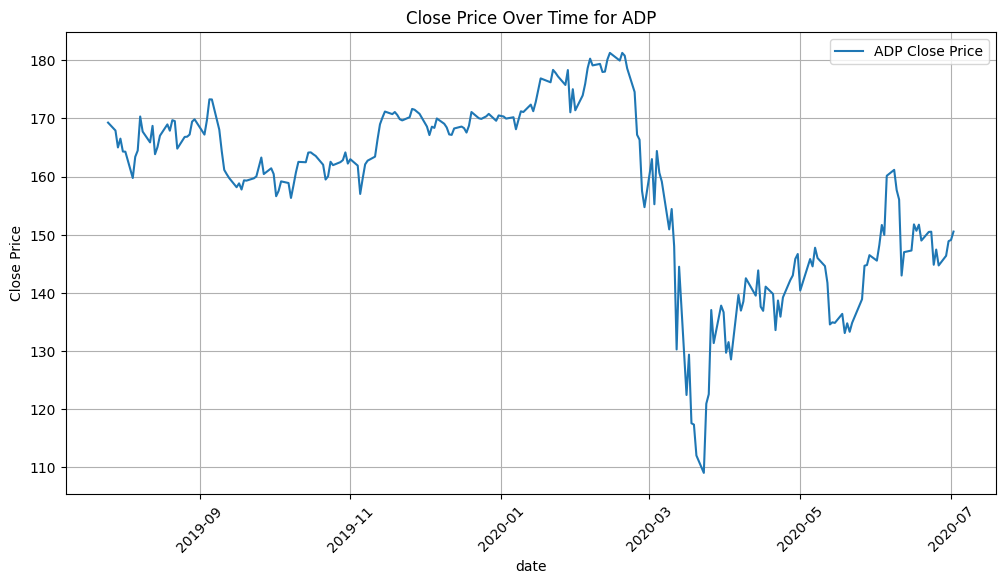

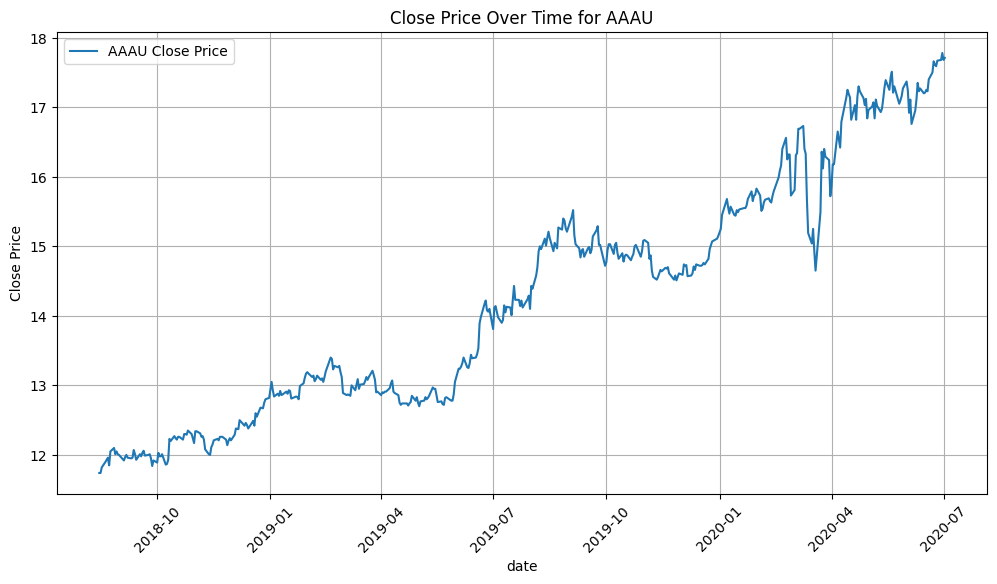

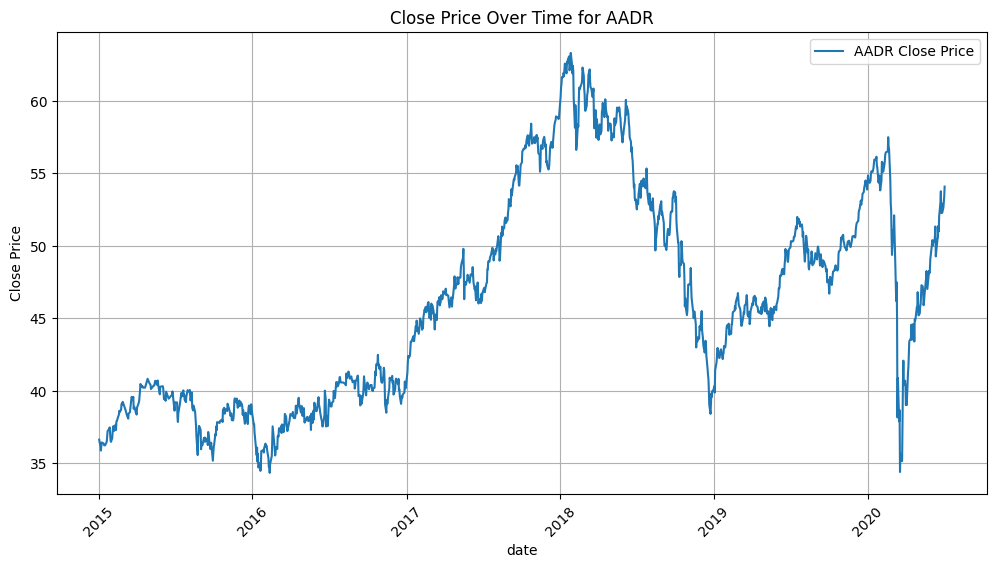

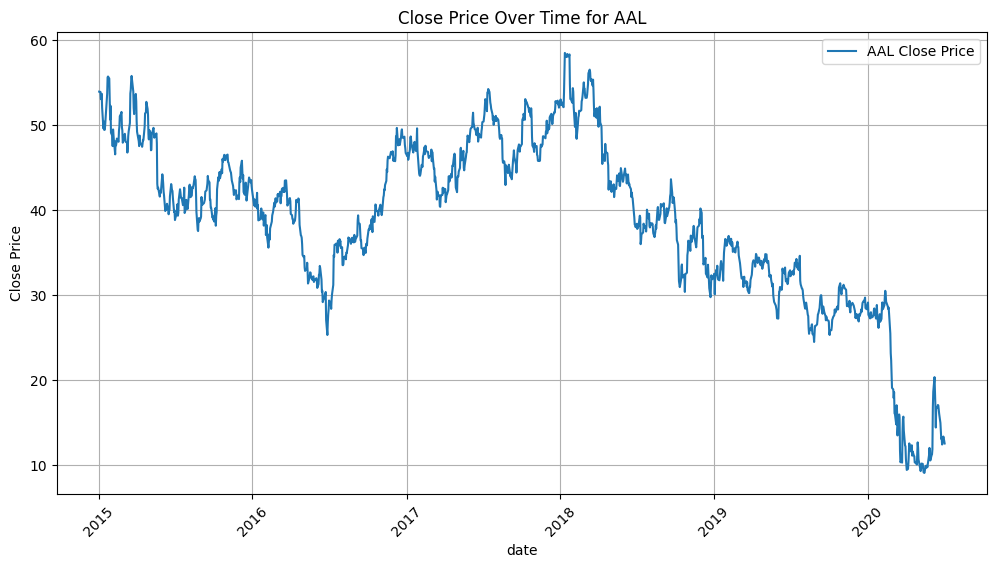

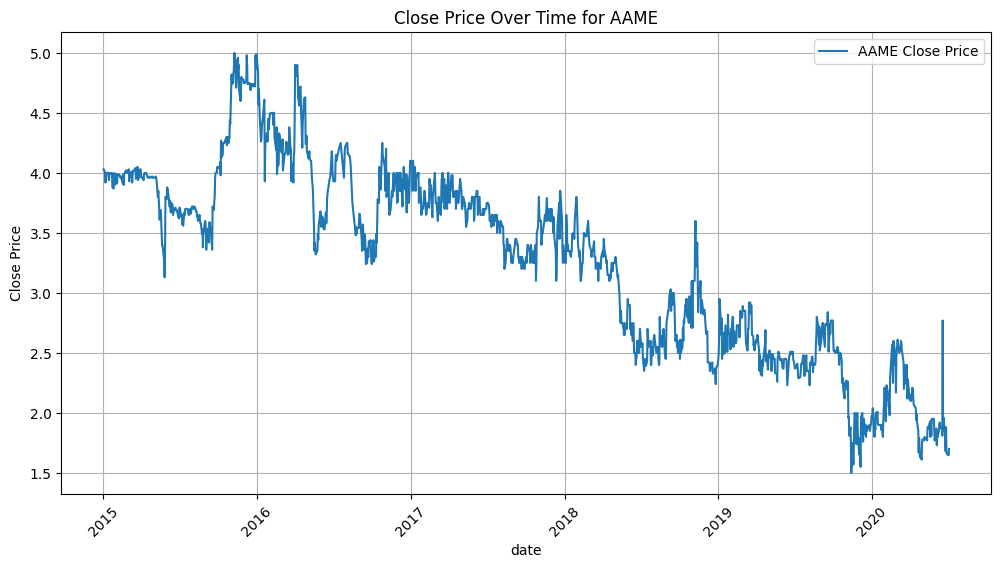

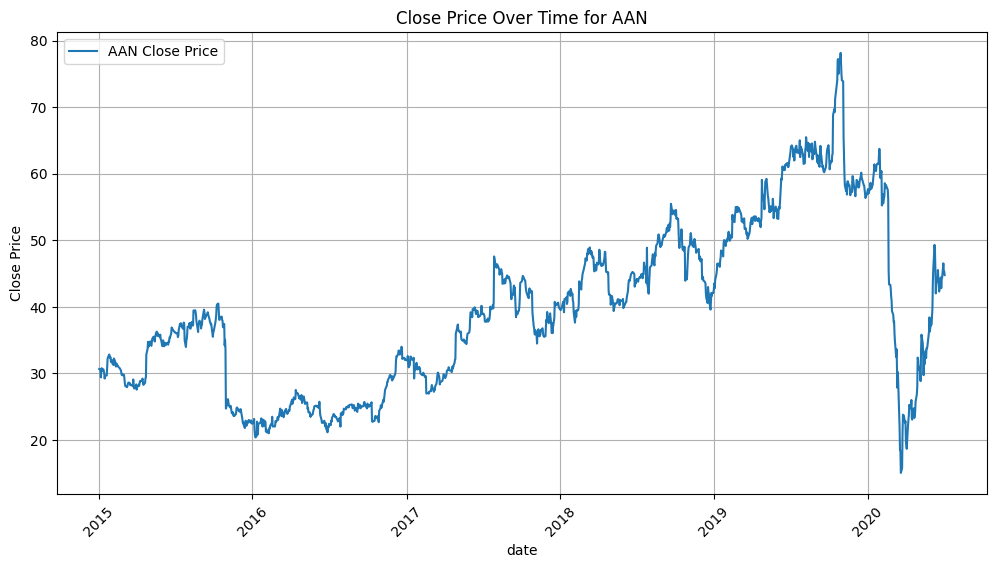

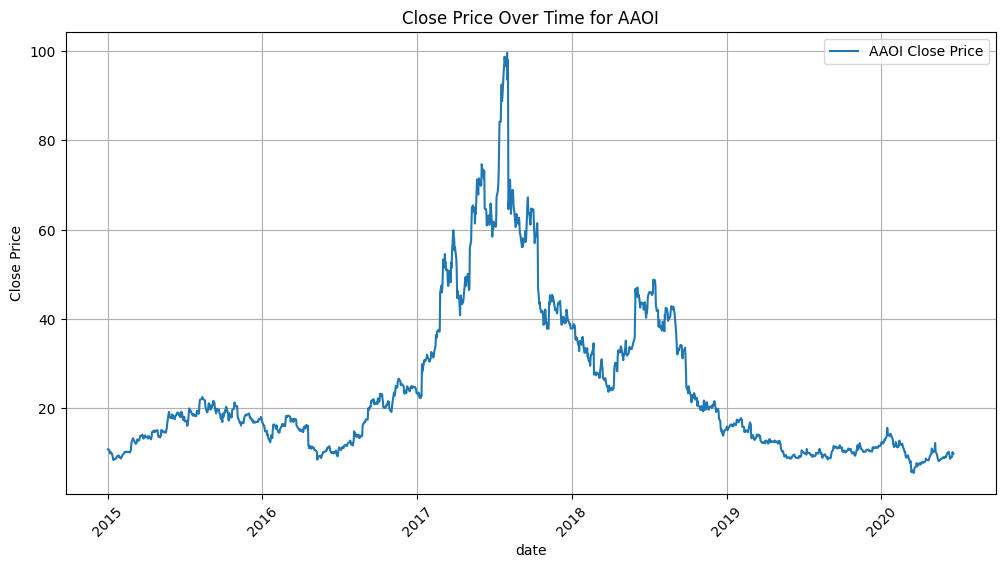

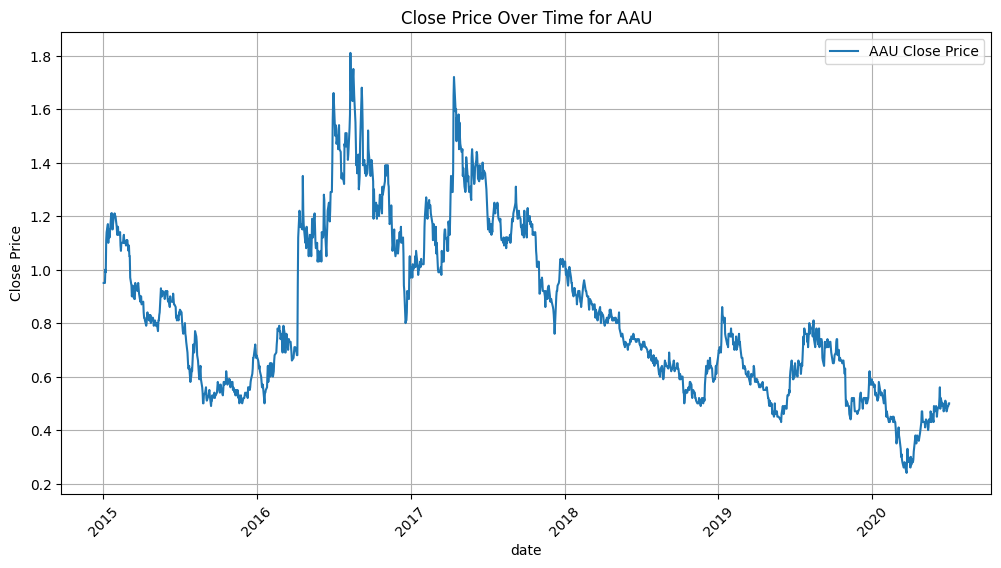

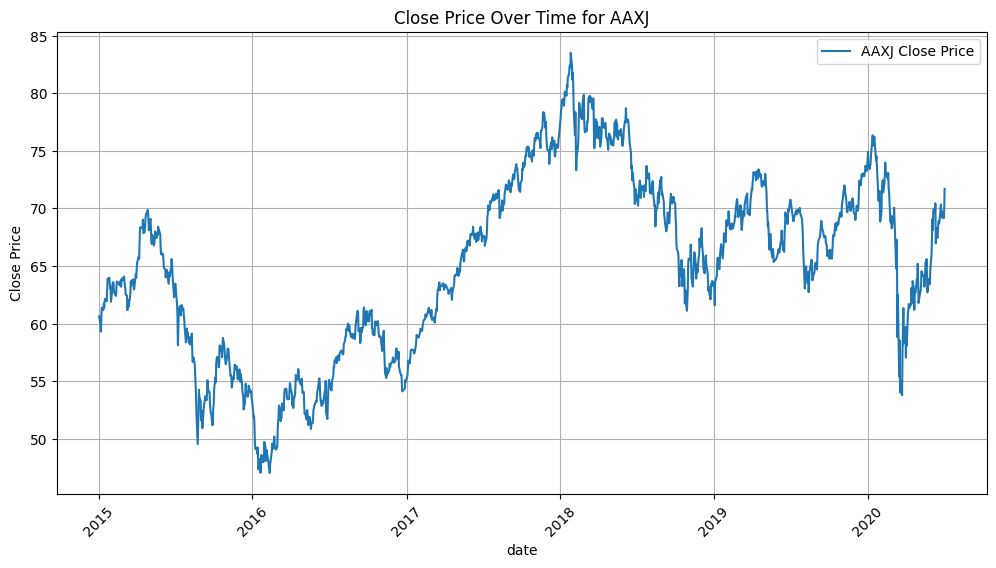

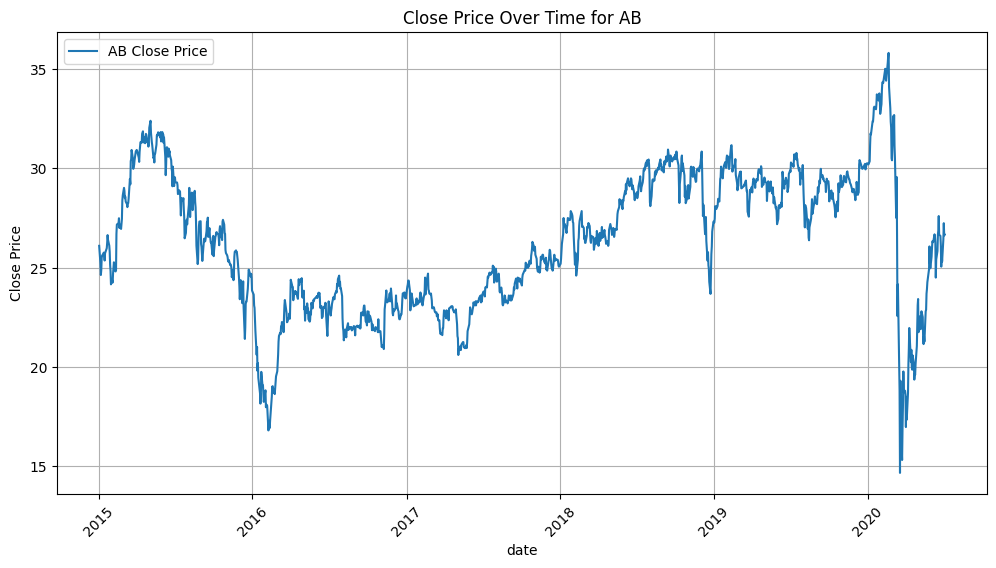

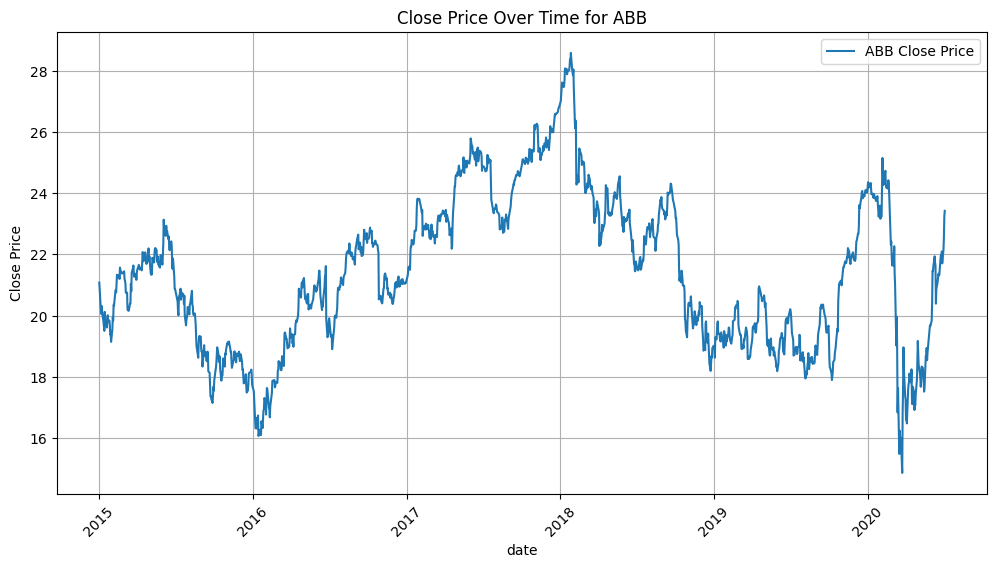

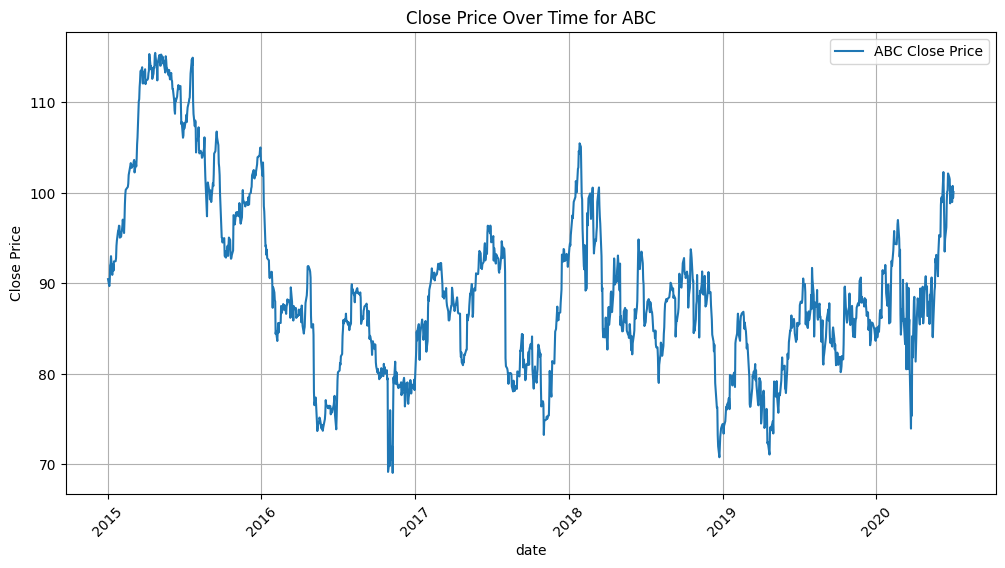

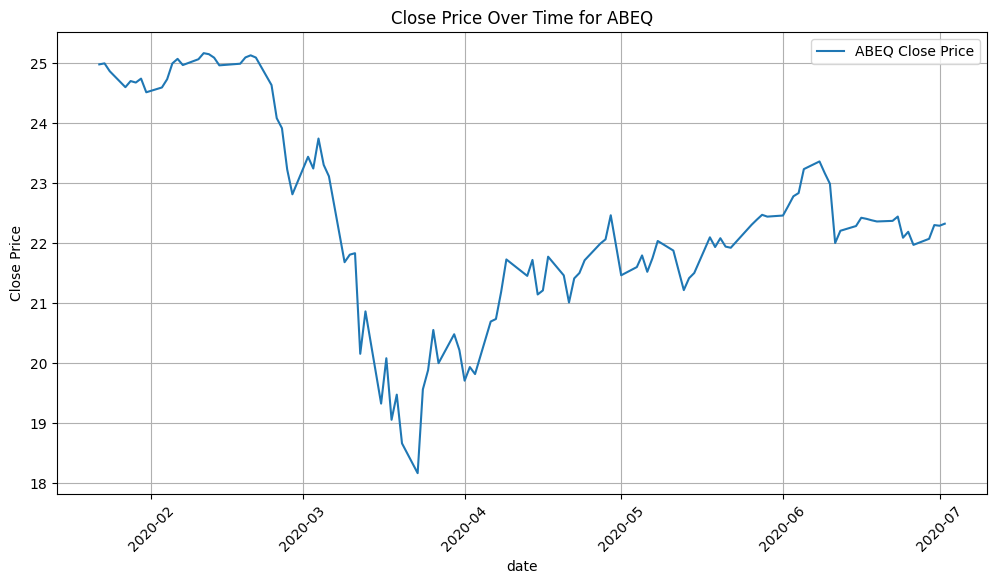

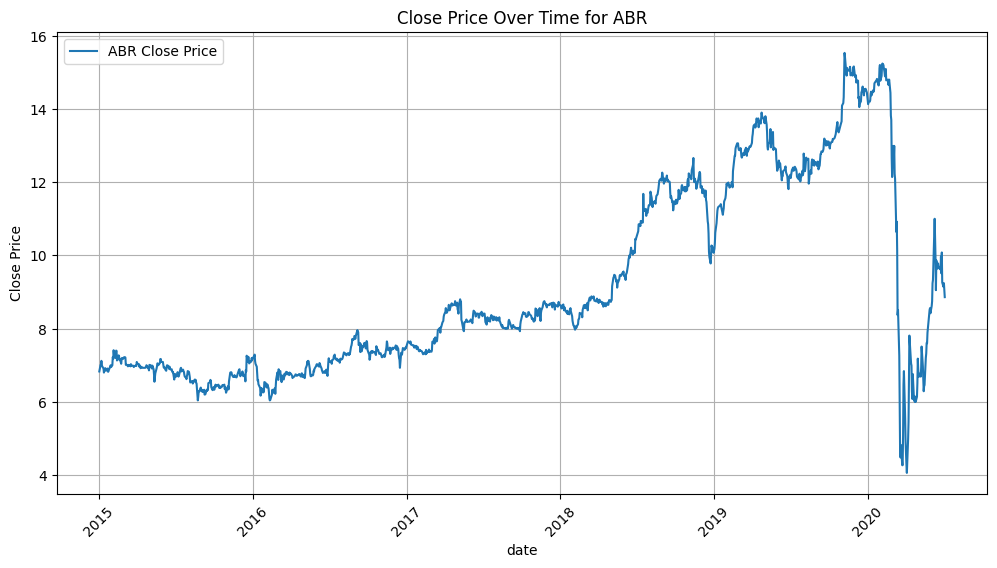

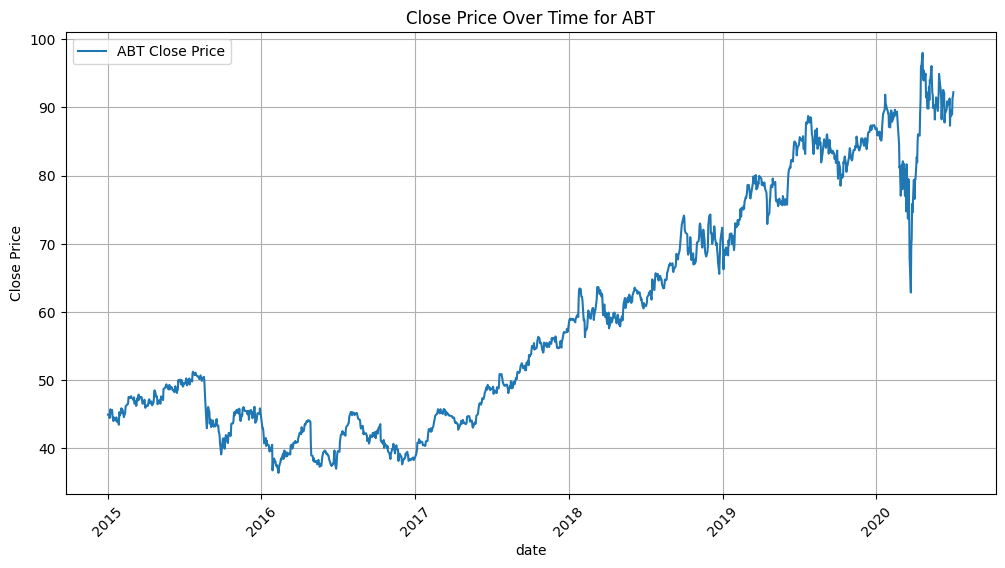

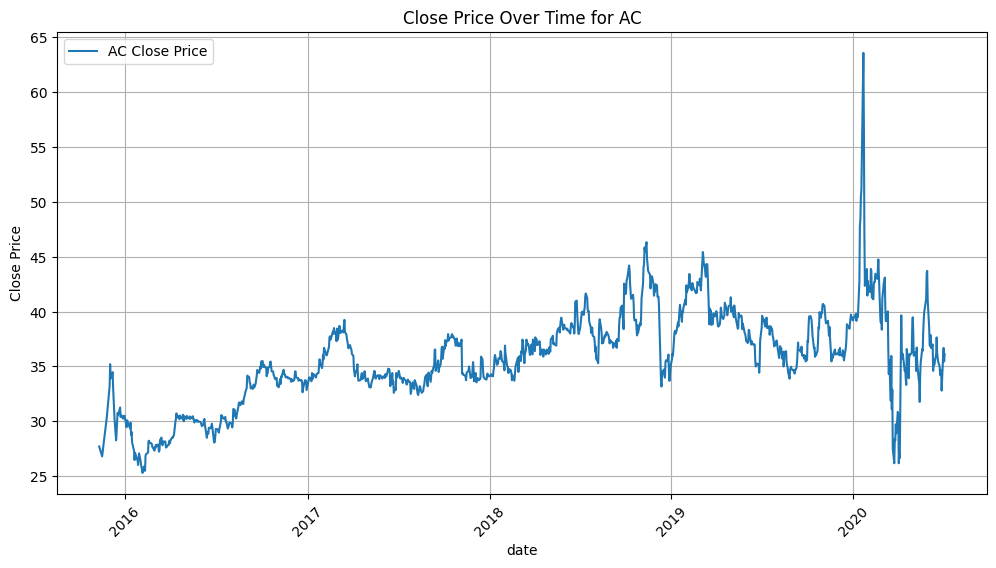

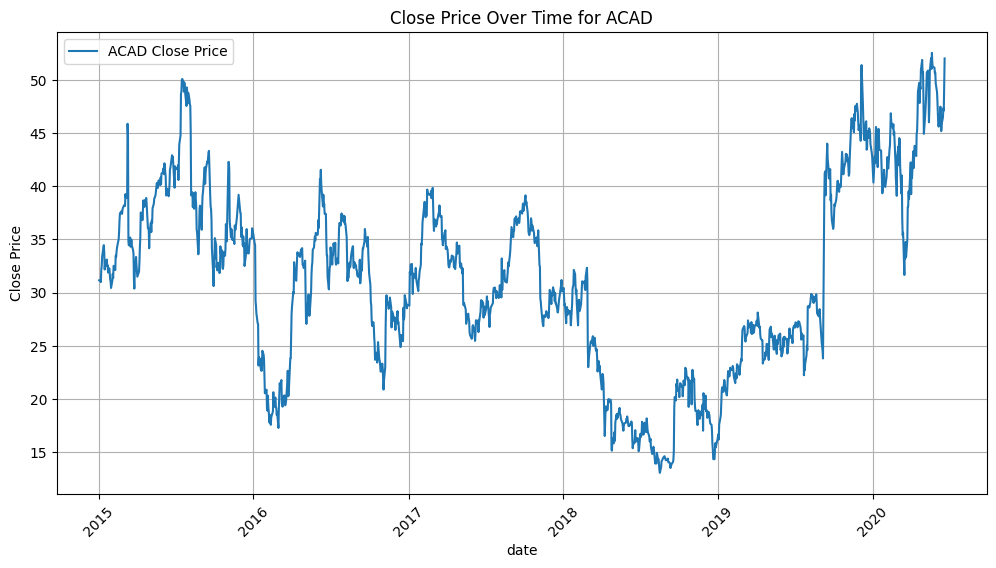

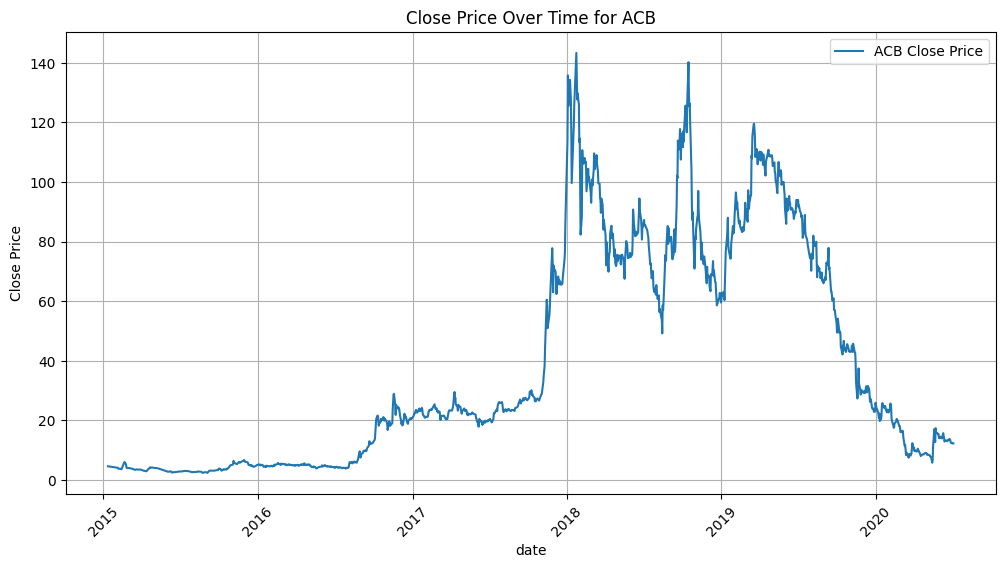

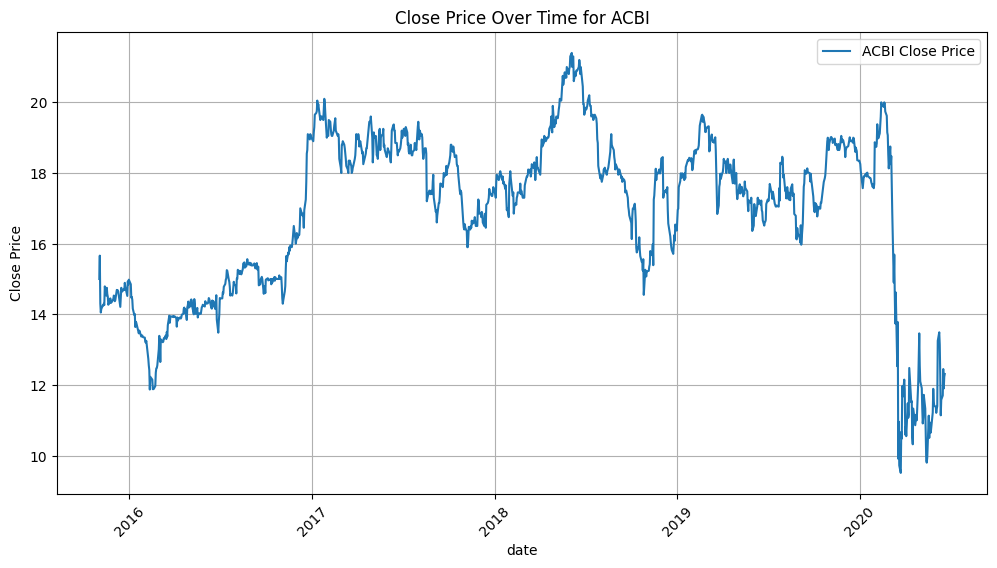

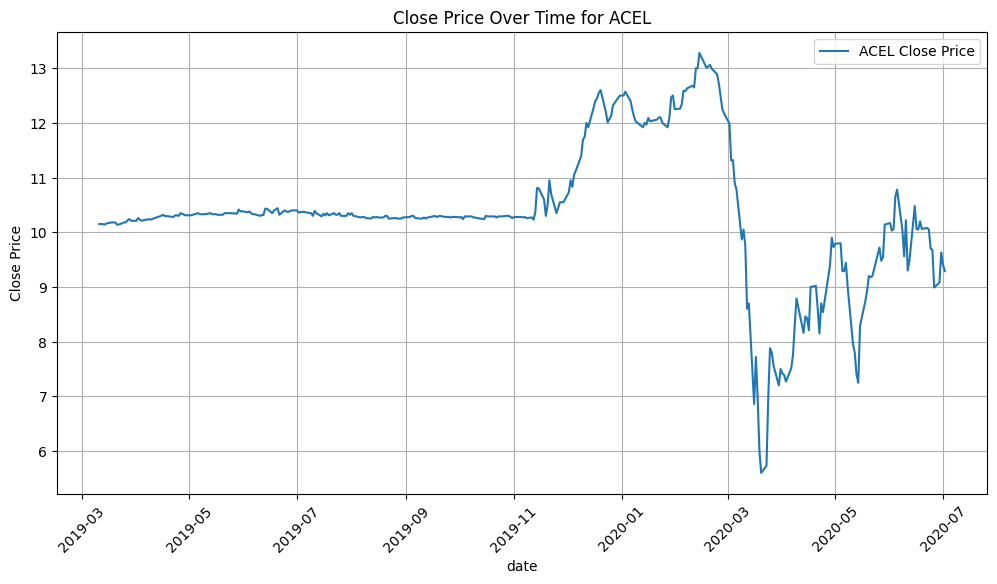

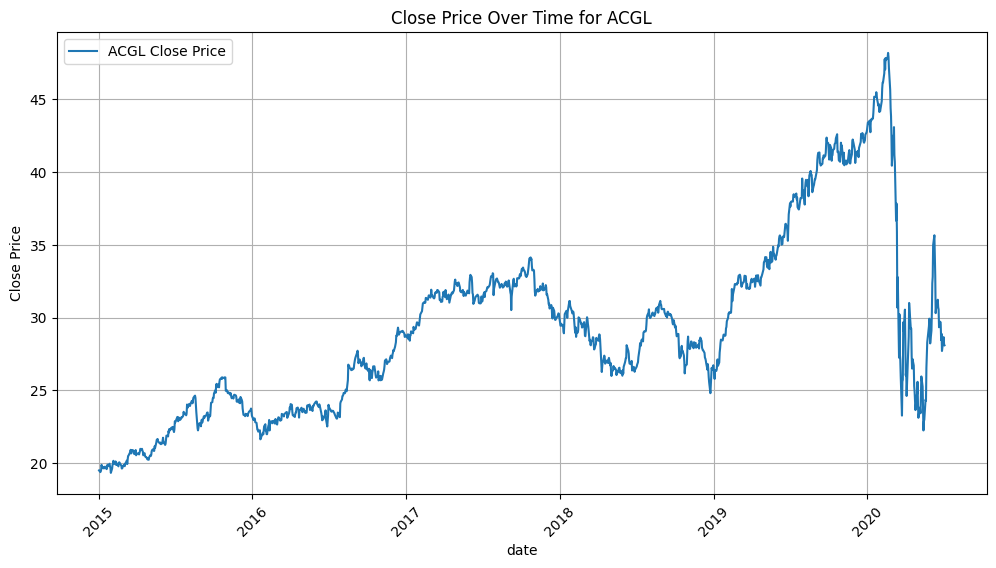

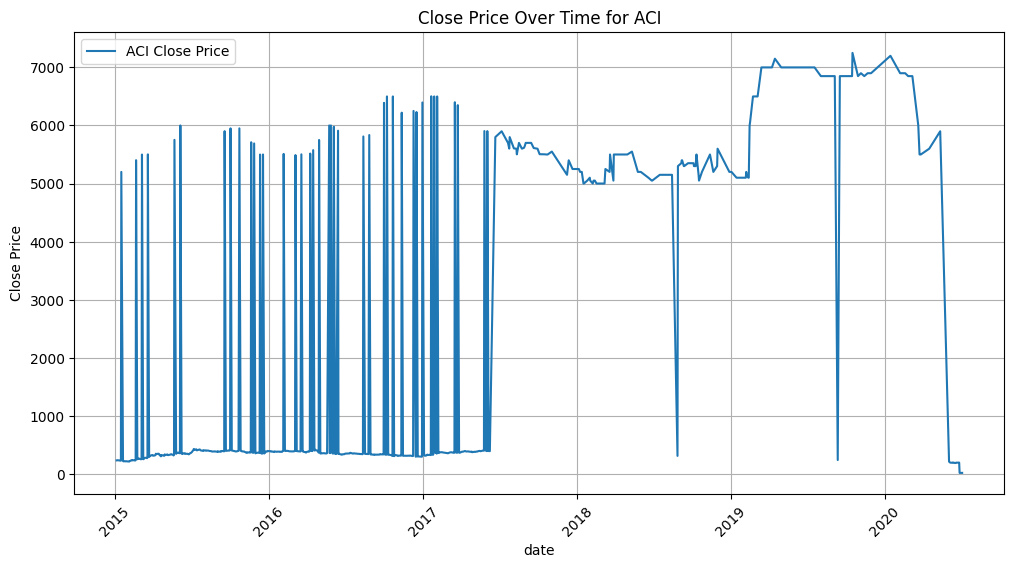

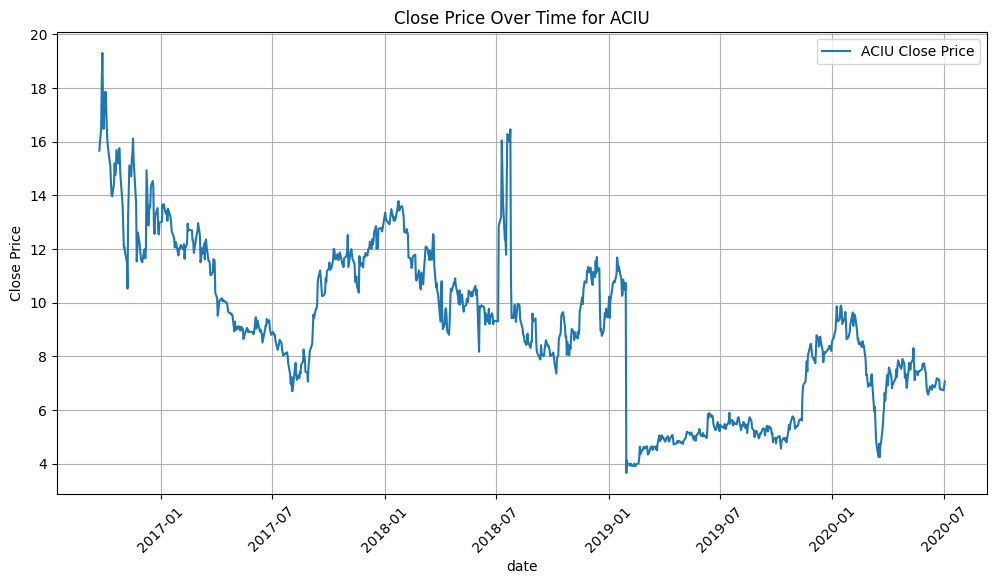

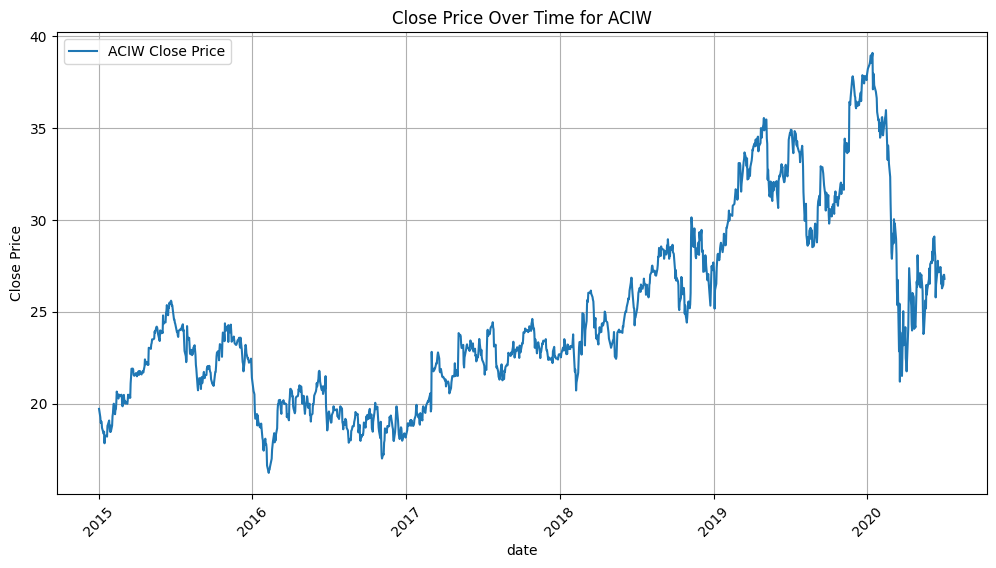

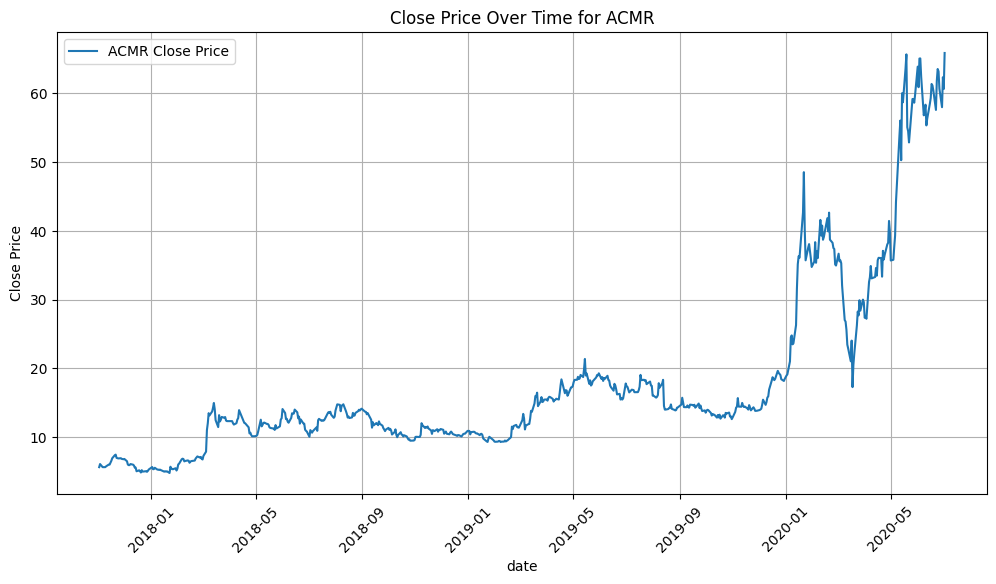

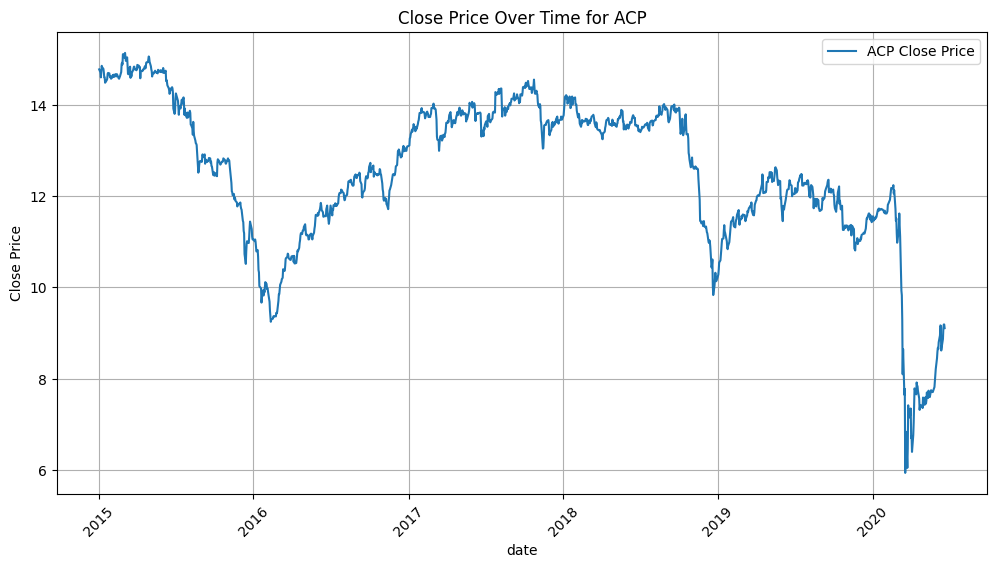

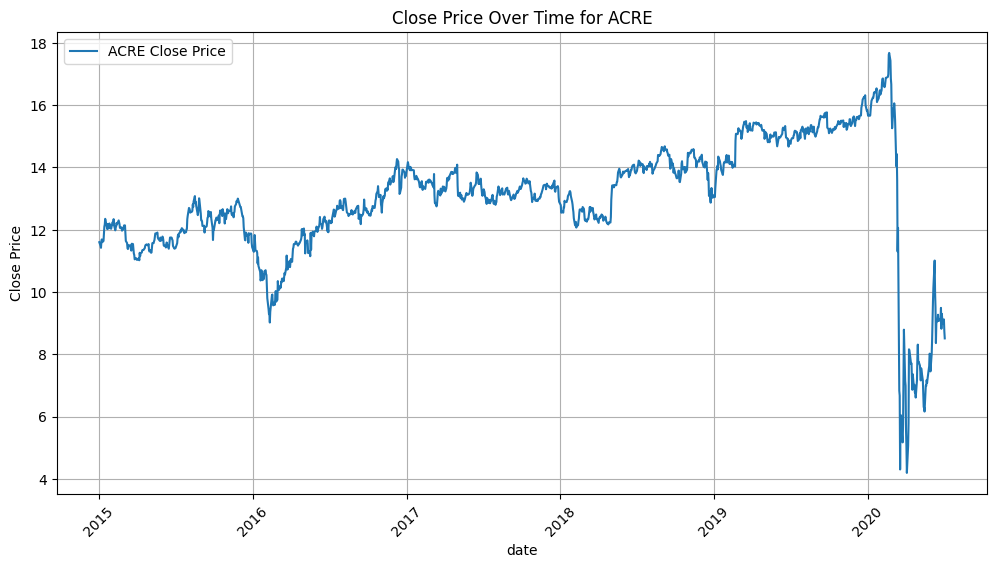

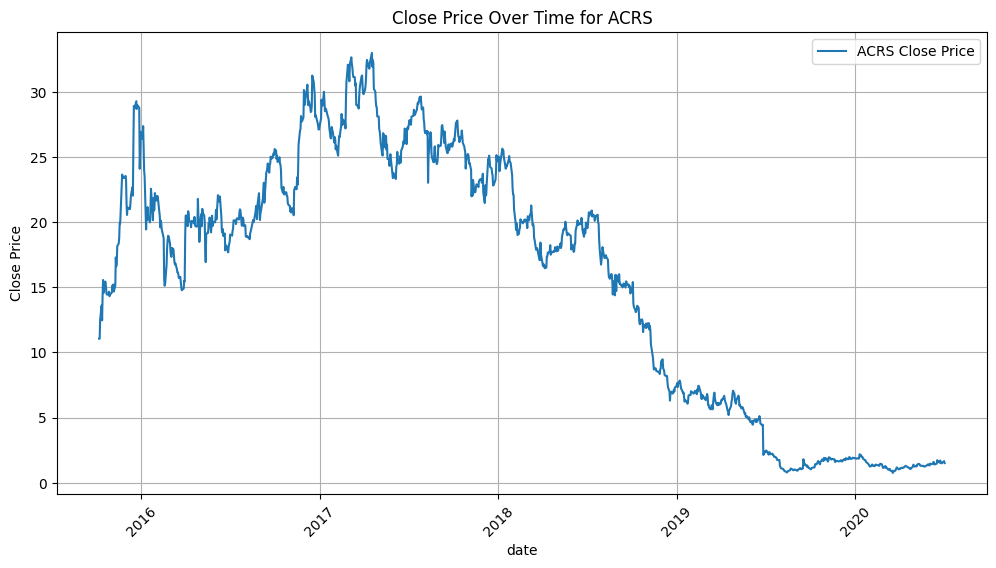

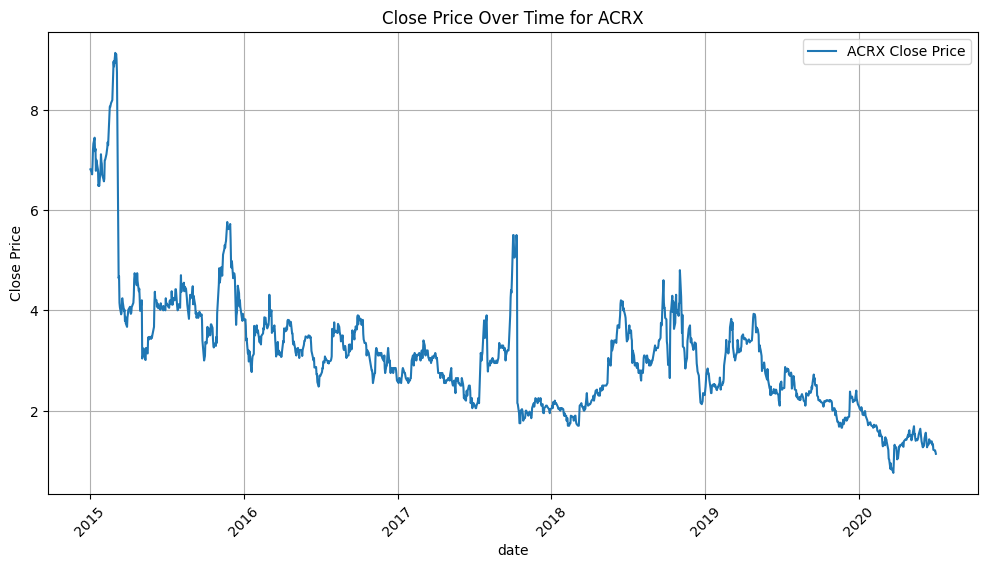

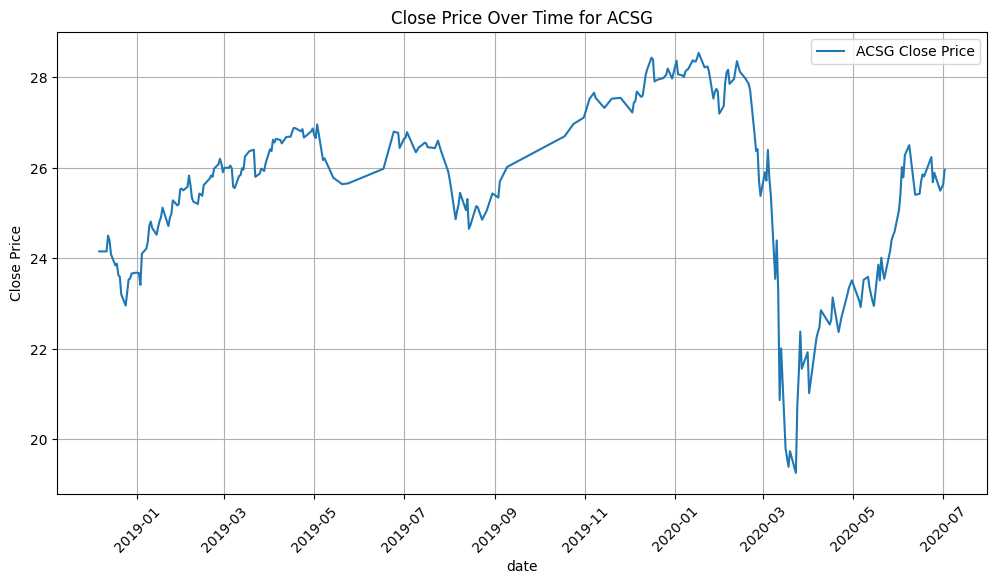

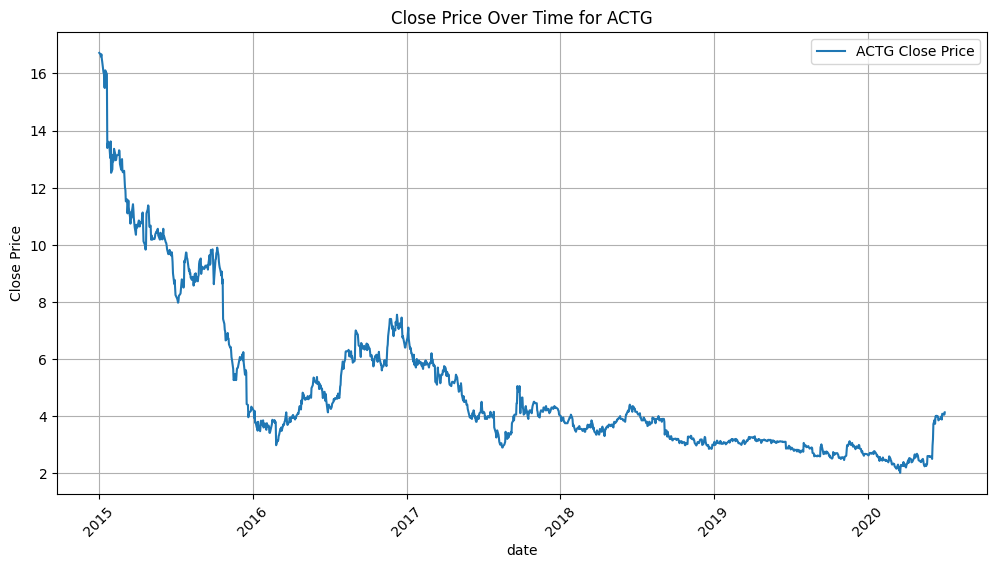

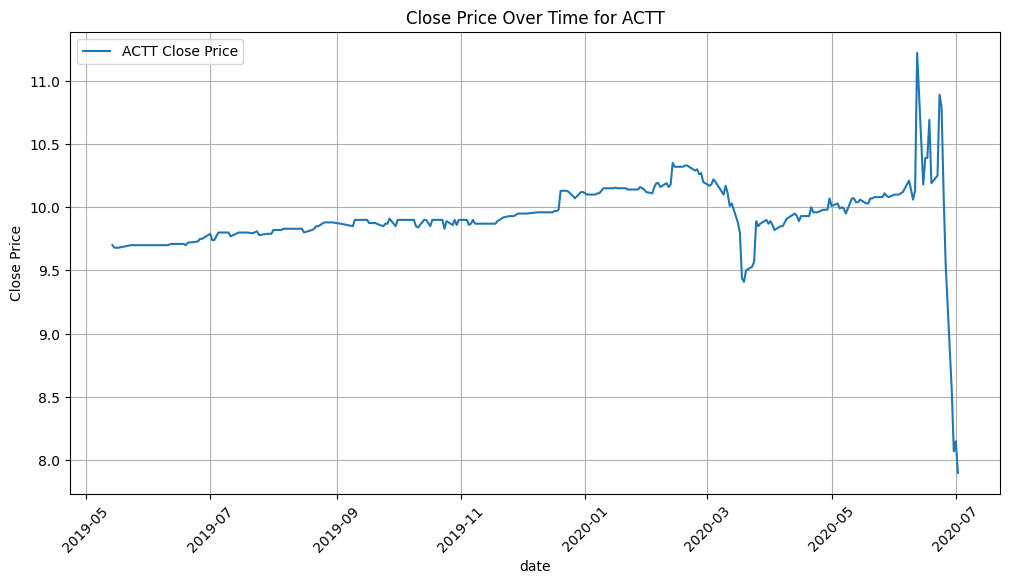

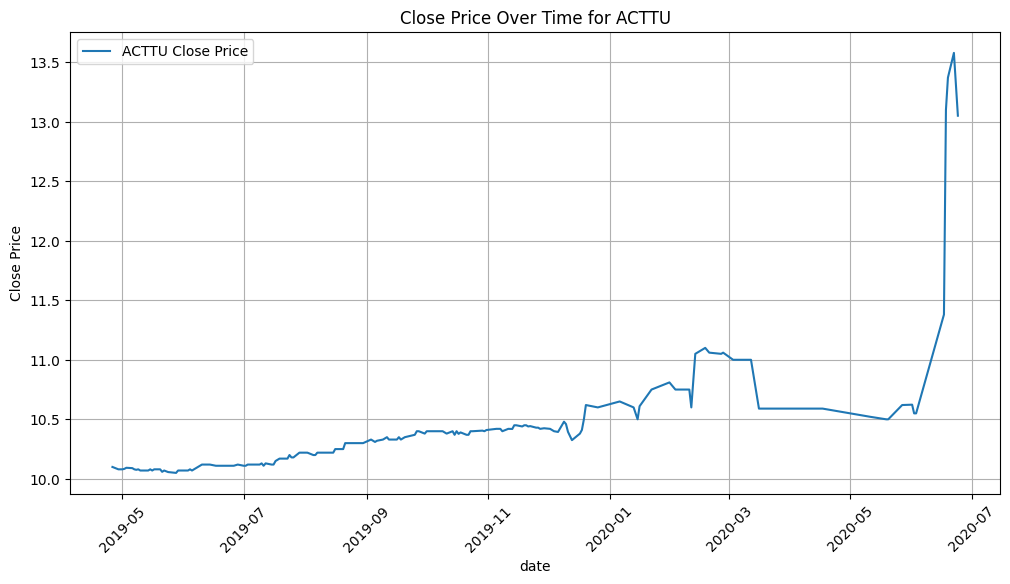

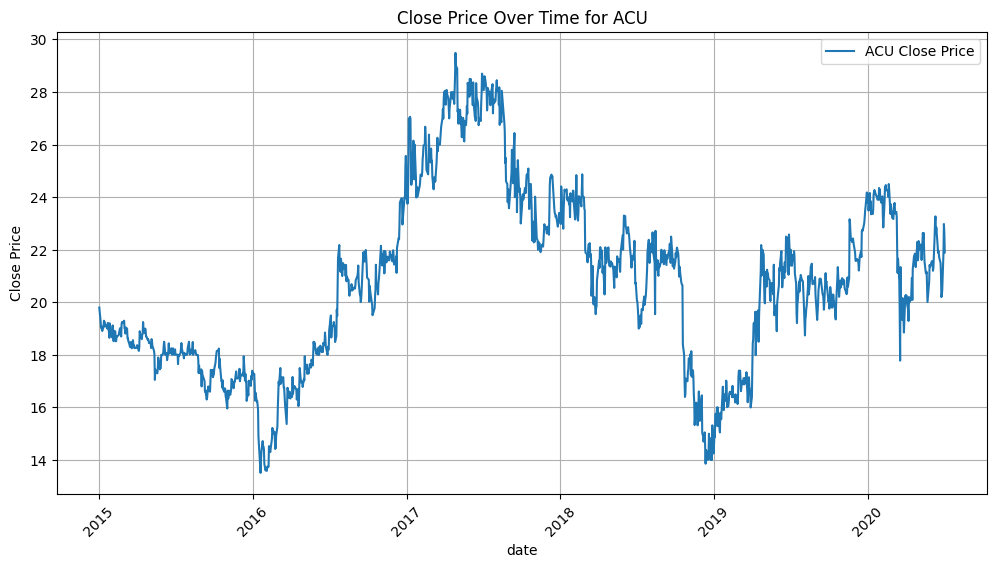

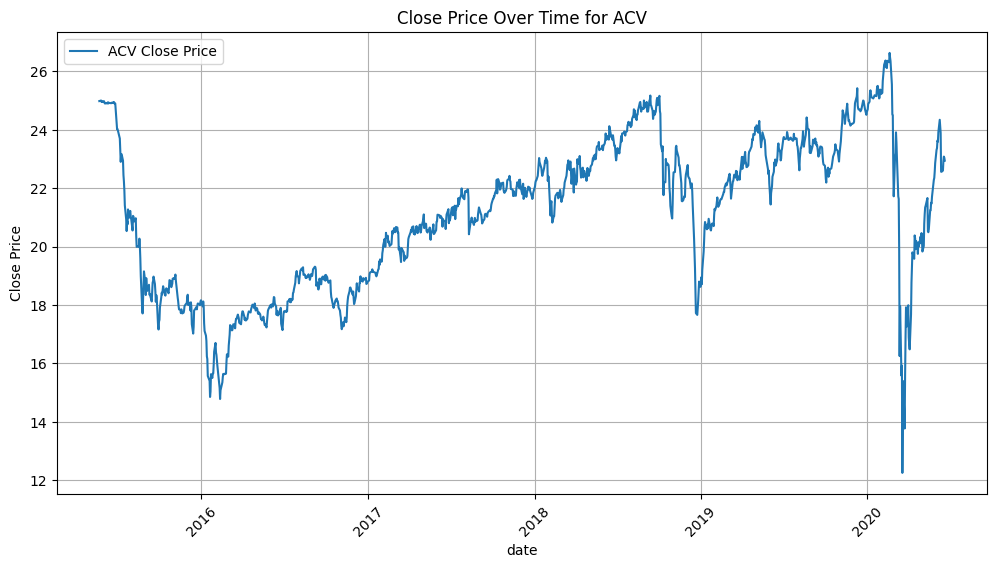

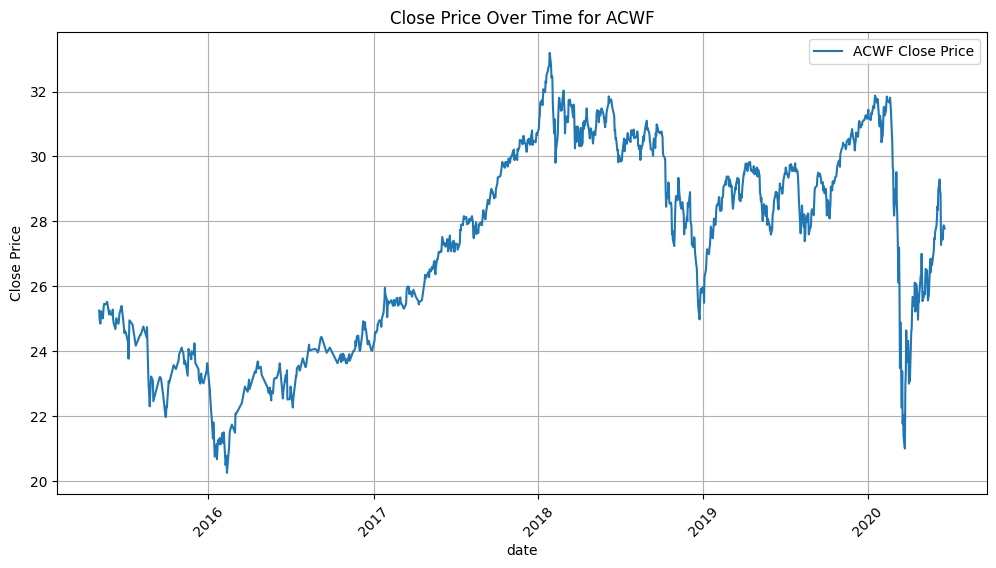

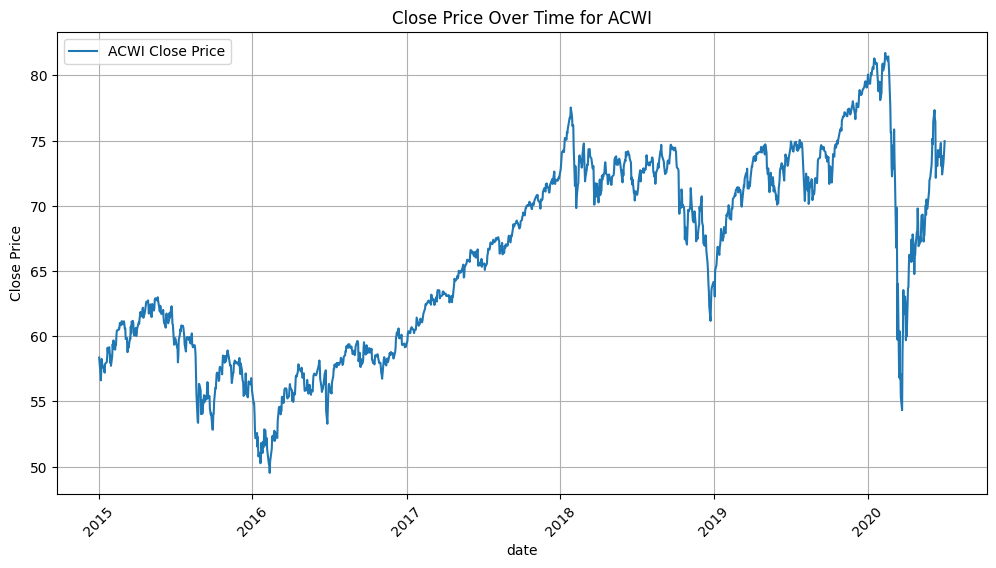

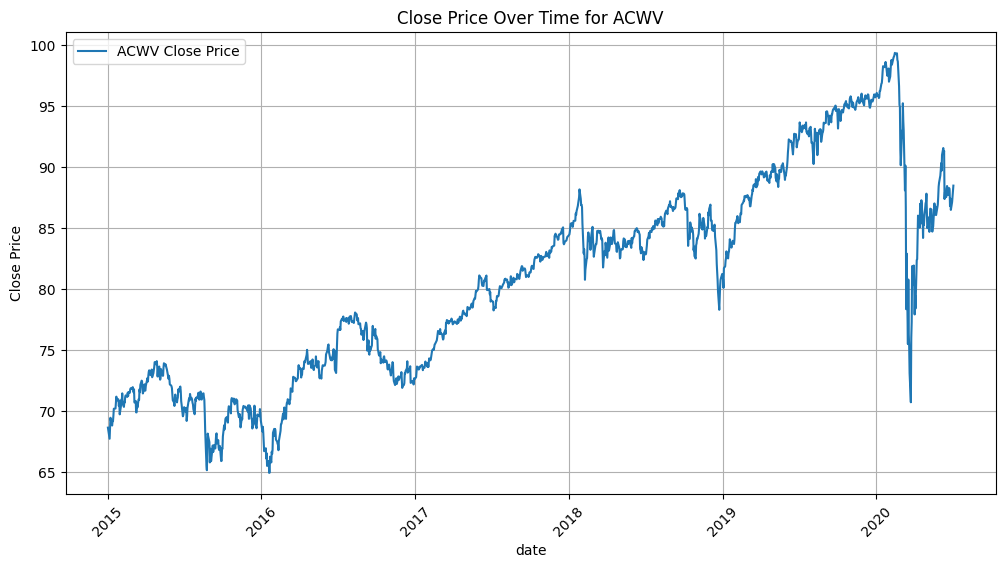

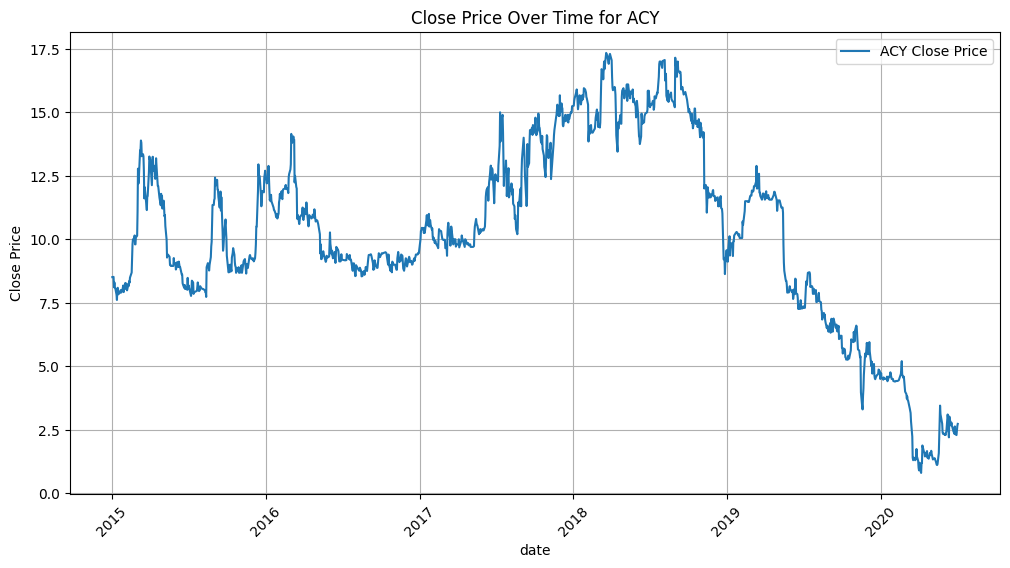

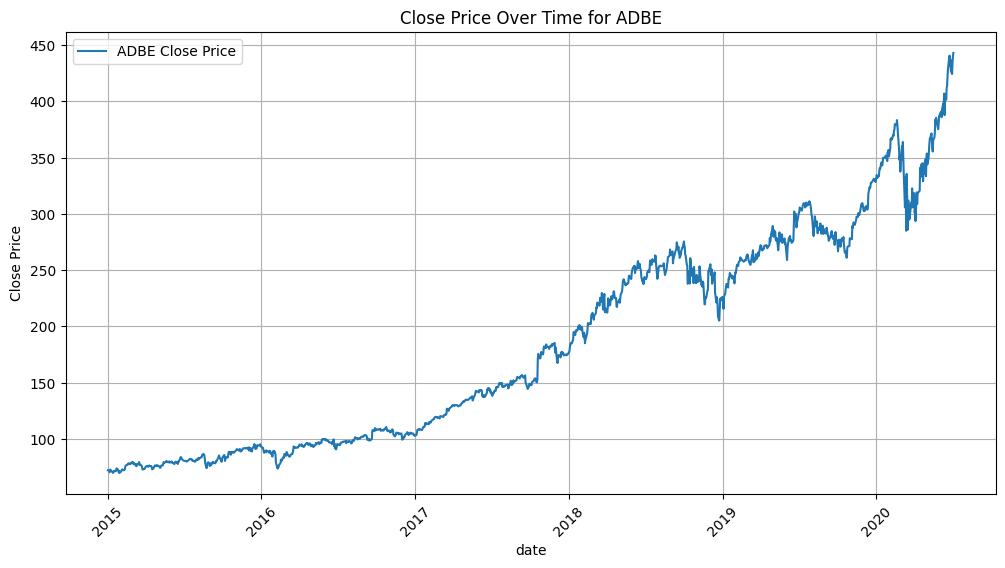

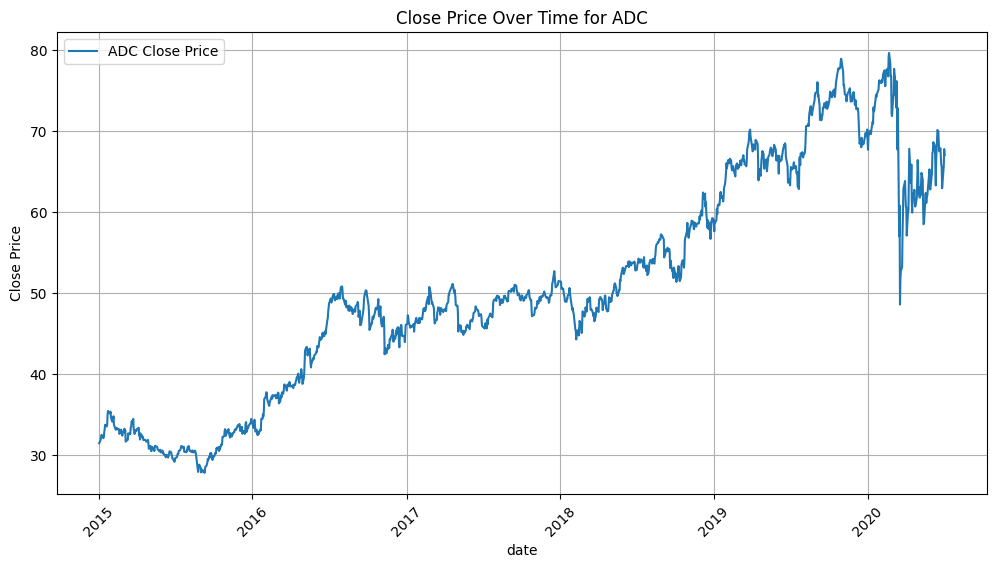

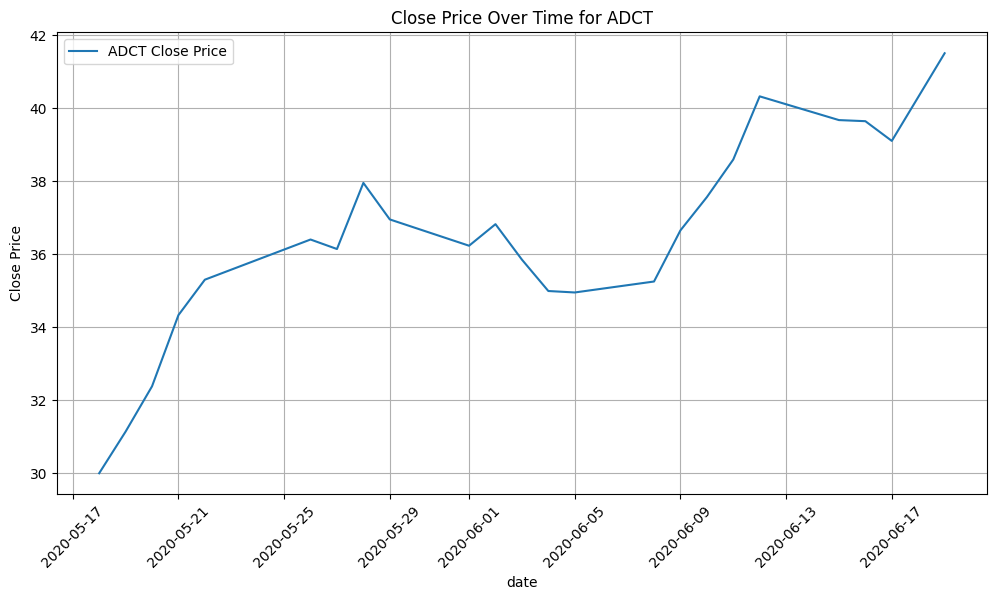

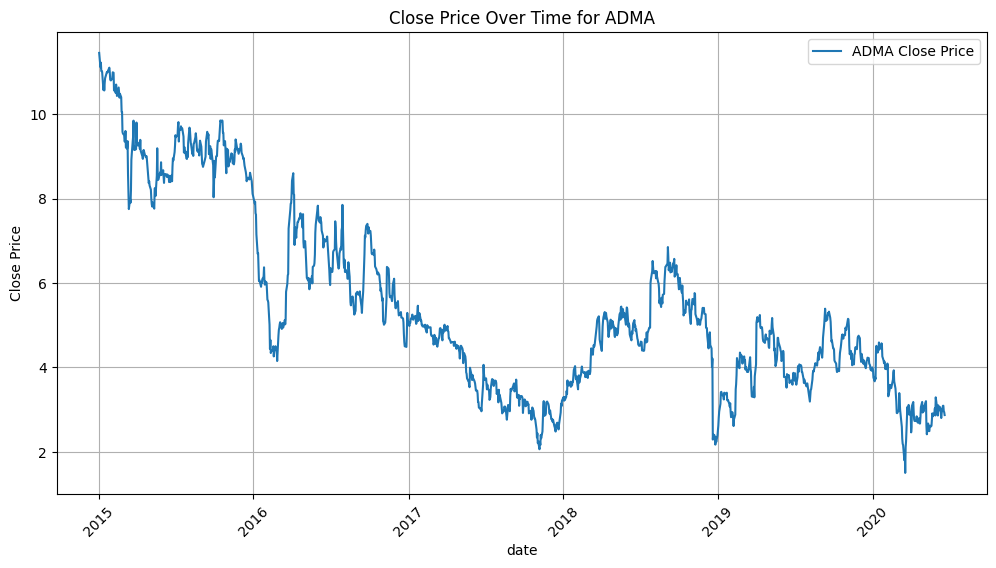

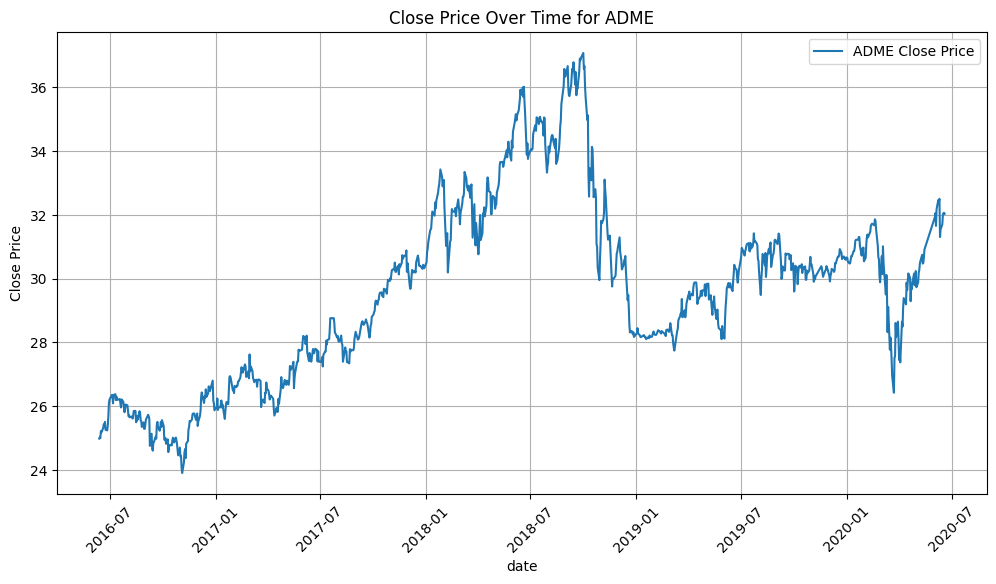

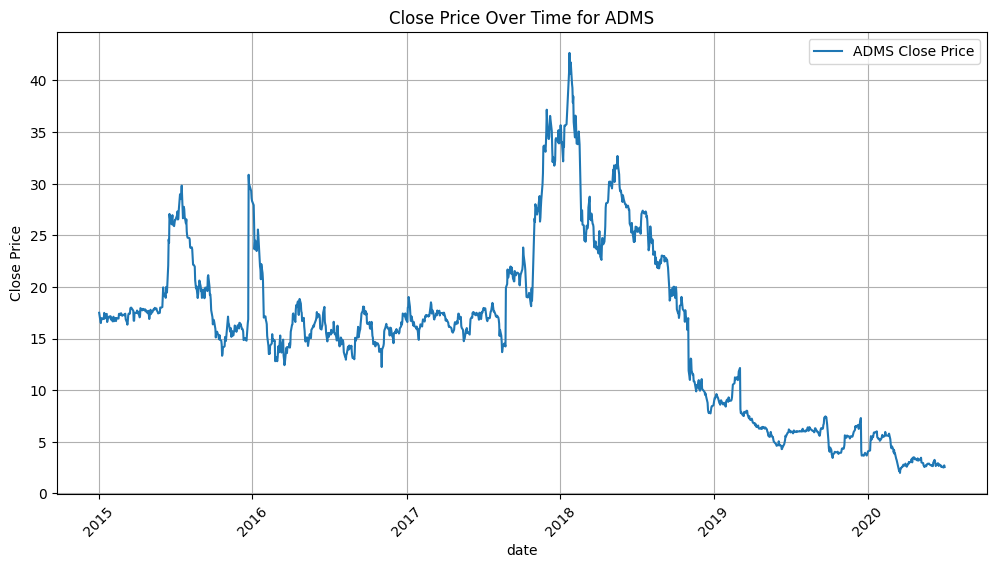

In [51]:
import matplotlib.pyplot as plt

# Unique symbols in the dataset
symbols = pandas_df['symbol'].unique()

# Generate line plots for each symbol
for symbol in symbols:
    firm_data = pandas_df[pandas_df['symbol'] == symbol]
    plt.figure(figsize=(12, 6))
    plt.plot(firm_data['date'], firm_data['close'], label=f"{symbol} Close Price")
    plt.title(f"Close Price Over Time for {symbol}")
    plt.xlabel("date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
len(pandas_df['symbol'].unique())

#

41

Correlation Analysis Across Companies:

Time Series Analysis with Moving Averages

In [52]:
# Add moving averages to the dataset
pandas_df['MA_20'] = pandas_df['close'].rolling(window=20).mean()
pandas_df['MA_50'] = pandas_df['close'].rolling(window=50).mean()
pandas_df['MA_200'] = pandas_df['close'].rolling(window=200).mean()
